In [2]:
import pandas as pd
import numpy as np

import time
from datetime import datetime

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import patsy

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV

import xgboost as xgb

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Executive summary

The project intends to estimate the banking customer ages from their product selection and demographic data. Then, to predict the products they are most likely to buy in the month proceeding the dataset.

On the age prediction, using XGBoost, predictions over 60% better than the RMSE of the mean baseline were achieved, with the model particularly successful on younger customers, but increasingly struggling with older customers, as similiar traits occur over wider age ranges as seniority increases.

On product recomendation, the first pass recomendation engine, based purely on product evolution on April to May (predicting June) beat the business justified baseline (predicting the most popular products inside the age group) by over two times, catching effectively 2/3rds of future purchases, enabling much more sophisticated marketing communication in the future.

## Introduction

This project is based off one of the two 2016 Santander Kaggle competitions, specifically the Product Recommendation Challenge: 

<https://www.kaggle.com/c/santander-product-recommendation>

The first place prize for the product recomendation modelling was $60,000.

An expansive, anonymised data set was provided with the challenge, covering one million customers and over 13 million rows of data. Across the seventeen months sampled, there are 48 columns of data per customer - 24 related to customer demographics or data itself, and 24 defining whether the customer owns each of the products in Santander's consumer portfolio.

This project will tackle the formal challenge, although the leaderboard is frozen, models can still be submitted and scored. Secondly, the project will take a second challenge - to predict the customer's age from the other features in the database - to become familiar with data, and to learn about applying regression models to 2GB datasets.

## Methods

On the age challenge, a number of methods will be applied - firstly linear regression, then GridSearch SGDRegressor, Gridsearch Lasso, ElasticNetCV, RandomizedSearchCV RandomForestRegressor, and finally XGBoost.

On the product recomendation, to start with similiar models will be applied - linear and xgboost trained on previous months. Then, specific product recomendation theory will be applied.

## Results

On the age challenge, the target of the exercise, a RMSE of under 5 years, couldn't be reached. The baseline of 17 years was reduced down to a best result of ~10.4 years (an R^2 of approximately 0.62), but, it took extensive model experimentation and hyper parameter tuning to reach that result, when a basic linear regression on standardised dataset with basic feature selection scored 10.7 years (R^2 of 0.6). 

On product recomendation, the first models beat the relatively sophisticated baseline by more than two times - 0.023 vs 0.009 on the MAP@7 score determined by Santander and Kaggle. The top public score of 0.032 shows further imprveimprovements can be made.

## Discussion / Interpretation of Results

On age prediction, juniors and university students were accurately modelled, beating the target RMSE. On customers between 25 and 115, the scores were dragged down. To a point this is understandable - someone living in a particular town in Spain, with a current account and a mortgage, could indeed be inside a very wide age range. Further study needs to be ran though, particularly on how to utilise the bimodal nature of age distribution in particular Spanish provinces to improve age prediction accuracy.

On product recomendation, I was please with the early results. A sophisticated baseline was set, and beat. It makes sense that complex boosted tree models can capture a lot of the predictive value across large, cmoplex datasets. Further accuracy can be achieved by examining the seasonal nature of the data, along with customer demographics, that are missing from my current model.

## Recomendations

Moving forward, it has been shown that there are limitations to predictive models, no matter how much data is thrown at them, when there is an underlying amount of variability in the data. It was very interested to see a linear regression, with basic feature selection, almost match an XGBoosted tree, with hours of hyper parameter tuning and feature engineering. However, that is not to rule out that there aren't more complicated, modern models that could be experimented with.

On product recomendation, the value of boosted trees shined through. Further accuracy should be gained by further experimentation - additional feature creation and hyper perameter tuning. Importantly, the xgboost implementation can be exported straight out of this workbook and implemented into Scala implementions that could feed into various marketing communication systems - both emails, and into the IT systems of Santander Sales advisors.

---

# Identify: Articulate Problem Statement/Specific goals & success criteria

The project is based on the Santander Product Reomendatation Kaggle, which ran between October and December 2016. <https://www.kaggle.com/c/santander-product-recommendation>. It was arranged by Santander (central HQ, Spain)



This project is made up of two problems:

* Devise a customer's age from their purchasing activity

* Determine a customer's next product purchases, based on their previous purchasing activity

Each task has it's own purpose, goal, methods of completion, and metrics of success

## Devise customer's ages from their purchasing activity

### Purpose

The objective of this exercise is threefold:

1. From a practical point of view, it is an effective proof of the data science methods that'll go on to solve the second challenge. If customer purchasing behaviour can be used to accurately model a personal variable such as age, it'll go some way to prove that the opposite can be done, and enhance the trust in the external facing customer recomendations made in the second half.

2. It will be a learning exercise beyond the EDA, to become intimate with the data, and to understand first hand the behaviours of different groups of customers. Also, by aiming for a single variable, it will let me learn what methods and models are realistic to process a dataset of this scale (>2GB CSV).

3. It will be a showcasing of many of the skills learnt in the first two months of the course, including EDA, and a variety of models, techniques and mathematics.

### Metrics and Success Criteria

Let's define a baseline accuracy for the project

In [3]:
ages = pd.read_csv("../../../../capstone_assets/train_ver2.csv", usecols=['age'],dtype={'age':np.float64},na_values=" NA",squeeze=True)
ages.dropna(inplace=True)

In [4]:
age_median = np.median(ages)
age_mean = np.mean(ages)

print "Median age  : ",age_median
print "Mean age    : ",age_mean

Median age  :  39.0
Mean age    :  40.1814649136


In [5]:
print "Mean squared error of a median baseline : ", np.mean((ages-age_median)**2)
print "Mean squared error of a mean baseline   : ", np.mean((ages-age_mean)**2)

Mean squared error of a median baseline :  296.723051784
Mean squared error of a mean baseline   :  295.327192442


In [6]:
print "Root mean squared error of a median baseline : ", np.mean((ages-age_median)**2)**0.5
print "Root mean squared error of a mean baseline   : ", np.mean((ages-age_mean)**2)**0.5

Root mean squared error of a median baseline :  17.2256509829
Root mean squared error of a mean baseline   :  17.1850863379


The median and mean are both relatively close together, at 39 and 40 respectively. Because of the similiarity, this means the mean square error, and RMSE, are also similiar. These are the scores to beat with the work, and I would hope to reduce the RMSE down to around five, and absolutely below ten, as banking behaviour will substantially change with age, and accurate estimates would be needed in order to make accurate product recomendations.

Secondly, a far better than baseline score is required, as there should be lots of indicators of age in the dataset - pensions skewing old, junior accounts skewing young, mortgages skewing middle age etc. Different provinces will have different average ages due to study, work and retirement migrations. There are a lot of strong potential indicators of age in the dataset, so with the correct model we should strive to reduce error.

### Determine customer's next product purchases

### Metrics and Success Criteria

Because the project originates from a Kaggle, the metric is clearly, and strictly defined:

Submissions are evaluated according to the Mean Average Precision @7MAP@7:

![product recomendation evaluation formula](assets/evaluation.png "Santander Kaggle Product Recomendation evaluation formula")



Which is delved into more detail here: https://www.kaggle.com/wiki/MeanAveragePrecision

The requirement is to predict the seven most likely products that the test customers would pick the following month. Higher points are given if the picked product(s) is earlier in the proposed list. If the customer doesn't buy a new product in the following month, no score is possible for that customer. So, the perfect score would be the % of customers that bought new products, which will be in the single digits.

Because the Kaggle is over, the public and private leaderboards are locked, but, submissions can still be submitted and scored.

For context, this was a $60k challenge, on which thousands of teams and individuals competed.

As the commercial intention of the product is to improve customer communications and marketing, I would like to at least match the accuracy of a banking specialist who reviewed an individual customer's data, but applying that on an industrial scale. I would predict the MAP score of a specialist, on a small set of customers, to be approximately 80 percent multiplied the number of customers who bought products. This is high! A baseline could be calculated by picking any random 7 of the 24, giving 30\% of points for the customers who bought products, but, the effective score would be lower because the ordering would likely be wrong. This ~\80\% accuracy per purchasing customer is the baseline I will set myself at the start of the project.

# Identify: Outline proposed methods & models	

The main reason for picking a kaggle is to access a large dataset on which to demonstrate the majority of models I have learnt to date, plus new models through independent learning.

### Age

On age, I will start with linear regression, expanded with chi squared feature selection. I will at the same time try lasso, ridge and elasticnet regression to see how the methods can deal with the mass of features in play.

It could be worth trying KNN, but, intuitivel I feel regression trees, particularly ensemble methods - trees, bagging, random forests and boosting, could help navigate the high dimensionality of the data, and the variety of scenarios and customer types hidden within it.

I would also like to turn the age hunt into a classification problem, predicting age ranges, to allow me to demonstrate the classification skills learnt to date (logistic classification, 

### Product Recommendation

This is a new area to me, but, I am excited at the prospect of building a recomendation engine.

Intuitively, the methods will be driven as much by the data processing and feature selection as the models and their configuration.

I will first focus on creating a variety of data sets, handling the time dimension in different ways. Currently the dataset works has a row, per customer, per month. I would like to try running a process opposite to melting, and have one row per customer, with months, and product counts and interations per month, as additional features. The width of this dataset would be very wide (17 months, 24 products, so 408 columns, maybe multiple times that if product evolution or lag, is captured as well as count).

As I generate time series skills, I can also use those on the data as it is currently structured.

Finally, EDA will be used to create smarter solutions for the data structure - if seasonality is key to banking product purchases, perhaps small ranges of months can be selected and processed.

In terms of models, a similiar workflow to the age set will be taken. Logistic regression will be the starting point on all data sets, but, I believe classification trees, and particularly ensemble methods, will be the most effective at covering the multitude of scenarios with the most accuracy. If I have the time, I would also like to see if I could build a neural network, perhaps to blend in with the predictions of the ensemble engine.

# Parse: Identify risks & assumptions	

### Risks

The first risk is the magnitude of the data being used. Up to now the largest .csv's I have worked on have been in the tens of megabytes - this project starts at two orders of magnitudes higher than that.

Furthermore, the, the dataset will likely increase in size as new features are enginerred. This creates a technological stress which must be considered. Every step will have to be taken to optimise the memory footprint of the piece (which starts in the EDA), and also to tune models to be computationally efficient, or the risk that work will be too slow, or infeasible, is real.

The next major concern is the time series element of the challenge - predicting future purchases based on history, when I haven't studied time series, or recomendation engines, in detail yet. This will be mitigated by both feature creation to reduce dimensionality in the dataset, to attempt to use classification tools, and by additional study, inside and outside of class, on time series, recomendation engines and the maths and models which drives them.

The third risk is class imbalances in the data - particular age ranges and product types will likely be underweighted in the dataset. However, with around a million customers, there should be sufficient details to allow weighting and ensemble modelling to mitigate the risk.

A fourth risk is the impact of the anonymisation process on the data. A variety of personal data will be missing entirely, which would be useful for feature creation, and for imputing missing data. This impacts both the accuracy that can be achieved, and how realistically this replicates a real world challenge. Also, because the dataset is a private one, with personal identifiers missing it'll be very difficult to supplement the data with external sources - for example, surveying social media to detect a customer's new job/school/house/baby, and the financial product prediction that would entail.

This risk can be mitigated somewhat by sense checking, learning about, and if necessary imputing the data from and against external datasources - salaries, populations, age ranges from Wikipedia <https://en.wikipedia.org/wiki/Economy_of_Spain>, the CIA Factbook <https://www.cia.gov/library/publications/the-world-factbook/geos/sp.html> and the Spanish Ministry of the Economy website <http://www.thespanisheconomy.com/portal/site/tse/>





# Parse: Create local PostgreSQL database	

Because the data is supplied in a CSV in a relatively complete form, I will not create a local database to work with (as demonstrated in the Titanic project), but, I will export the cleaned dataframe(s) to CSV, so they can be imported clean, instead of having to re-process the data every time the notebook is restarted.

# Parse: Query, Sort, & Clean Data	

First step, read the 2.3GB CSV provided by Santander <https://www.kaggle.com/c/santander-product-recommendation/data> into a Pandas dataframe.

In [7]:
train_ver2 = pd.read_csv("../../../../capstone_assets/train_ver2.csv")

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


And let's check all the expected ~13m rows are available: 

In [8]:
print train_ver2.shape

(13647309, 48)


13.6 million rows, and 48 columns - my largest dataset yet!

---------------

The dimensions of the data is the first challenge of the exersise. To understand the problem, first lets see how big the dataframe memory footprint is:

In [9]:
memory_footprint = train_ver2.memory_usage(index=False).sum()

print "Memory Footprint : %s GB" % round((float(memory_footprint) / (1024**3)), 2)

Memory Footprint : 4.88 GB


Nearly 5 gigabytes, before it has been cleaned.

This immediately has an impact on sytem resources:

![Mac OS X Activity Monitor, Python2.7, 5.6GB](assets/memory_footprint.png "Nearly 6GB Memory footprint on the unprocessed dataframe, before calculations")

For this cleaning process, not only will the accuracy of the data have to be considered, but, also the dimensions of it. For example, pandas by default is converting binary product indicators into int64s:

In [10]:
train_ver2['ind_ahor_fin_ult1'].value_counts()

0    13645913
1        1396
Name: ind_ahor_fin_ult1, dtype: int64

In [11]:
train_ver2.ix[0,'ind_ahor_fin_ult1'].dtype

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


dtype('int64')

Cleaning and converting these columns to int8's, or booleans, could save substantial memory footprint, which will both save resources, but also speed up computation, and also allow faster and more complex modelling 

---

The data cleaning in this project will thus take three parts:
* Clean data per column, through both imputation, and removal where necessary.
* Optimise, where necessary, the data types used by Pandas.
* Export the cleaned data to a new CSV, so that the processing does not have to be repeated everytime the project restarts. This cleaned data can also be compressed and shared with the project notebooks where necessary to improve collaboration.

The first two steps will be ran in tandem, with the third following.

### Clean data per column & optimise data type

There are three types of issue I will consider when cleaning the data:

* Missing data
* Incorrectly/inconsistently encoded data
* Incorrect data

Which I will tackle together across the 48 columns, one by one, followed by data type optimisation and exportation.

First, lets see the columns we are dealing with :

In [12]:
train_ver2.columns

Index([u'fecha_dato', u'ncodpers', u'ind_empleado', u'pais_residencia',
       u'sexo', u'age', u'fecha_alta', u'ind_nuevo', u'antiguedad', u'indrel',
       u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
       u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'tipodom',
       u'cod_prov', u'nomprov', u'ind_actividad_cliente', u'renta',
       u'segmento', u'ind_ahor_fin_ult1', u'ind_aval_fin_ult1',
       u'ind_cco_fin_ult1', u'ind_cder_fin_ult1', u'ind_cno_fin_ult1',
       u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1', u'ind_ctop_fin_ult1',
       u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1', u'ind_deme_fin_ult1',
       u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1', u'ind_fond_fin_ult1',
       u'ind_hip_fin_ult1', u'ind_plan_fin_ult1', u'ind_pres_fin_ult1',
       u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1', u'ind_valo_fin_ult1',
       u'ind_viv_fin_ult1', u'ind_nomina_ult1', u'ind_nom_pens_ult1',
       u'ind_recibo_ult1'],
      dtype='object')

#### fecha_dato

In [13]:
train_ver2.fecha_dato.value_counts(dropna=False).sort_values('index',ascending=True)

2015-01-28    625457
2015-02-28    627394
2015-03-28    629209
2015-04-28    630367
2015-05-28    631957
2015-06-28    632110
2015-07-28    829817
2015-08-28    843201
2015-09-28    865440
2015-10-28    892251
2015-11-28    906109
2015-12-28    912021
2016-01-28    916269
2016-02-28    920904
2016-03-28    925076
2016-04-28    928274
2016-05-28    931453
Name: fecha_dato, dtype: int64

No missing data, no inconsistent values.

In [14]:
train_ver2.fecha_dato.dtypes

dtype('O')

In [15]:
def print_memory_size(var,cap="MB"):
    if cap == "GB":
        print var.memory_usage()/(1024**3), cap
    elif cap == "MB":
        print var.memory_usage()/(1024**2), cap

In [16]:
print_memory_size(train_ver2['fecha_dato'])

104 MB


Only issue we have is the date is stored as an object, not a datetime, could potentially complicate running computations on the column in the future. Let's fix that by converting to the data type datetime:

In [17]:
train_ver2['fecha_dato'] = pd.to_datetime(train_ver2['fecha_dato'],yearfirst=True)

In [18]:
train_ver2.fecha_dato.dtypes

dtype('<M8[ns]')

In [19]:
print_memory_size(train_ver2['fecha_dato'])

104 MB


The memory footprint has remained stable, but, with the benefit of being able to query specific months and years.

#### ncodpers

ncodpers is the user ID used by Santander Spain. It *should* be relatively clear and coherent.

In [20]:
print train_ver2.ncodpers.head(5)
print train_ver2.ncodpers.tail(5)

0    1375586
1    1050611
2    1050612
3    1050613
4    1050614
Name: ncodpers, dtype: int64
13647304    1166765
13647305    1166764
13647306    1166763
13647307    1166789
13647308    1550586
Name: ncodpers, dtype: int64


In [21]:
train_ver2.ncodpers.isnull().sum()

0

In [22]:
train_ver2.ix[0,'ncodpers'].dtype

dtype('int64')

No missing values, consistent looking values, only issue is the full int64 data type, which could be optimised a little.

In [23]:
print_memory_size(train_ver2.ncodpers)

104 MB


In [24]:
np.max(train_ver2.ncodpers)

1553689

In [25]:
print_memory_size(pd.to_numeric(train_ver2['ncodpers'],downcast='unsigned'))

52 MB


In [26]:
train_ver2['ncodpers'] = pd.to_numeric(train_ver2['ncodpers'],downcast='unsigned')

Converting to an unsigned integer is logical, as there are no negative nubmers in the ID. Reducing the length from 64 to 32 bits maintains the accuracy but halves the memory footprint.

#### ind_empleado

This is a category for customers which are also employees, and their category if that is the case:

A active, B ex employed, F filial, N not employee, P pasive

In [27]:
train_ver2.ind_empleado.value_counts(dropna=False)

N      13610977
NaN       27734
B          3566
F          2523
A          2492
S            17
Name: ind_empleado, dtype: int64

There are two issues - NaN data, which should be fixed to N, and 'S' data, which I will take to be a miscategorisation of 'P' data. 

In [28]:
train_ver2['ind_empleado'].fillna('N',inplace=True)
#DataFrame.replace(to_replace=None, value=None, inplace=False, limit=None, regex=False,
#method='pad', axis=None)
train_ver2['ind_empleado'].replace('S','P',inplace=True)

This cleans the errors, next step is to optimise:

In [29]:
train_ver2['ind_empleado'].dtypes

dtype('O')

In [30]:
print_memory_size(train_ver2['ind_empleado'])

104 MB


104MB doesn't seem bad for 13m rows, but, lets see if we can optimise further with the category type:

In [31]:
#train_ver2['ind_empleado'] = train_ver2['ind_empleado'].to_string()
train_ver2['ind_empleado'] = train_ver2['ind_empleado'].astype('category')

In [32]:
train_ver2['ind_empleado'].dtypes

category

In [33]:
print_memory_size(train_ver2['ind_empleado'])

13 MB


From 104MB down to 13MB! Highly optimised. This, along with other categories, will be dummied later, nearly as efficient columns, but with more model compatibility.

In [34]:
train_ver2['ind_empleado'].value_counts()

N    13638711
B        3566
F        2523
A        2492
P          17
Name: ind_empleado, dtype: int64

#### pais_residencia

This is the customer's country of residence.

In [35]:
train_ver2['pais_residencia'].value_counts(dropna=False).head(10)

ES     13553710
NaN       27734
FR         5161
AR         4835
DE         4625
GB         4605
US         3651
CO         3526
IT         2947
RO         2931
Name: pais_residencia, dtype: int64

Spain represents the following % of customers :

In [36]:
round(train_ver2['pais_residencia'].value_counts(dropna=False).head(1).values/float(train_ver2.shape[0]),4)

0.9931

So, I'm going to make the assumption that missing data belongs to that of Spanish customers:

In [37]:
train_ver2['pais_residencia'].fillna('ES',inplace=True)

Now, lets optimise the size down:

In [38]:
print_memory_size(train_ver2['pais_residencia'])

104 MB


In [39]:
train_ver2['pais_residencia'] = train_ver2['pais_residencia'].astype('category')

In [40]:
print_memory_size(train_ver2['pais_residencia'])

13 MB


Another substantial MB reduction

#### Sexo

The gender of the customer.

In [41]:
train_ver2['sexo'].value_counts(dropna=False)

V      7424252
H      6195253
NaN      27804
Name: sexo, dtype: int64

There are three options here - fill with the modal value, V, consider perhaps the missing data is perhaps a choice by the customer (they identify with a gender not provided, they wished to witheld the infomation, amongst other cases) and leave it blank, or perhaps the row is corrupted.

Let's review the third option:

In [42]:
train_ver2[train_ver2['sexo'].isnull()].head(10)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
261,2015-01-28,1050741,N,ES,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,0.0,0.0,0
1029,2015-01-28,1051017,N,ES,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,0.0,0.0,0
1063,2015-01-28,1051064,N,ES,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,0.0,0.0,0
1154,2015-01-28,1051387,N,ES,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,0.0,0.0,0
1779,2015-01-28,1048660,N,ES,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,0.0,0.0,0
1850,2015-01-28,1049775,N,ES,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,0.0,0.0,1
1867,2015-01-28,1049774,N,ES,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,0.0,0.0,0
1886,2015-01-28,1049838,N,ES,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,0.0,0.0,0
1922,2015-01-28,1049700,N,ES,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,NaN,NaN,0
2142,2015-01-28,1049406,N,ES,NaN,NA,NaN,NaN,NA,NaN,...,0,0,0,0,0,0,0,0.0,0.0,0


It looks like the latter is the case - certain rows are missing a variety of data. Lets double check the same number of missing values are missing across the df:

In [43]:
train_ver2.isnull().sum()

fecha_dato                      0
ncodpers                        0
ind_empleado                    0
pais_residencia                 0
sexo                        27804
age                             0
fecha_alta                  27734
ind_nuevo                   27734
antiguedad                      0
indrel                      27734
ult_fec_cli_1t           13622516
indrel_1mes                149781
tiprel_1mes                149781
indresi                     27734
indext                      27734
conyuemp                 13645501
canal_entrada              186126
indfall                     27734
tipodom                     27735
cod_prov                    93591
nomprov                     93591
ind_actividad_cliente       27734
renta                     2794375
segmento                   189368
ind_ahor_fin_ult1               0
ind_aval_fin_ult1               0
ind_cco_fin_ult1                0
ind_cder_fin_ult1               0
ind_cno_fin_ult1                0
ind_ctju_fin_u

The same 28k row figure is continuously coming up - I either it is missing from their systems, or perhaps was over-anonymised! As it represents well under a % of the total data, I will remove the rows.

In [44]:
train_ver2 = train_ver2[train_ver2['sexo'].notnull()]

In [45]:
train_ver2.isnull().sum()

fecha_dato                      0
ncodpers                        0
ind_empleado                    0
pais_residencia                 0
sexo                            0
age                             0
fecha_alta                      0
ind_nuevo                       0
antiguedad                      0
indrel                          0
ult_fec_cli_1t           13594712
indrel_1mes                122047
tiprel_1mes                122047
indresi                         0
indext                          0
conyuemp                 13617697
canal_entrada              158391
indfall                         0
tipodom                         1
cod_prov                    65857
nomprov                     65857
ind_actividad_cliente           0
renta                     2766607
segmento                   161633
ind_ahor_fin_ult1               0
ind_aval_fin_ult1               0
ind_cco_fin_ult1                0
ind_cder_fin_ult1               0
ind_cno_fin_ult1                0
ind_ctju_fin_u

This has made a big impact on the missing values overall. Next, lets optimise the gender category:

In [46]:
print_memory_size(train_ver2['sexo'])

207 MB


In [47]:
train_ver2['sexo'] = train_ver2['sexo'].astype('category')

In [48]:
print_memory_size(train_ver2['sexo'])

116 MB


A ~50% saving on memory footprint.

In [49]:
train_ver2['sexo'].value_counts()

V    7424252
H    6195253
Name: sexo, dtype: int64

#### Age

Age of the customer. Let's check for missing values, then the top and tail:

In [50]:
train_ver2['age'].isnull().sum()

0

No missing values, good start!

In [51]:
train_ver2['age'].value_counts(dropna=False).sort_index().tail(10)

106    192
107    155
108     72
109     60
110     43
111     49
112     48
113     24
115     39
116     12
Name: age, dtype: int64

116 is slightly aggressive as an age, given that wikipedia see's spain's oldest person as 115: <https://en.wikipedia.org/wiki/List_of_Spanish_supercentenarians>. I will remove all rows over 115. (With more personal data, it would be possible to investigate the high ages further - they could be a data entry error on date of birth, an issue translating old bank files from paper to digital.. Either way it is too high and could cause a problem).

In [52]:
train_ver2.age.value_counts(dropna=False)

23     542682
24     527526
22     524620
21     500941
20     370847
25     345664
26     250641
 23    237202
43     231501
44     229359
42     227604
45     224073
41     221432
46     214320
 22    211694
 24    207259
40     205668
47     204715
27     203881
48     194513
39     186583
49     179384
 21    175047
28     174169
50     169287
38     166836
51     159013
37     154889
52     152009
29     149706
        ...  
107       439
103       419
  3       415
108       384
105       307
104       307
110       218
109       205
111       203
106       192
107       155
112       140
  2       124
113        93
108        72
109        60
116        51
111        49
112        48
115        43
110        43
115        39
113        24
114        22
117        14
116        12
127         8
163         8
164         3
126         3
Name: age, Length: 234, dtype: int64

Here is a crucial lesson, and fix, in my code. Originally I ran the following code to drop the ages above 115.

In [53]:
#train_ver2 = train_ver2[train_ver2['age'] > 115]

However, this was a mistake, as Pandas imported a large number of the age fields as strings. This meant, by filtering on a number, it removed a number of legitimate values. Whilst only 12 rows show as ages > 115, the following data was deleted:

In [54]:
train_ver2[train_ver2['age'] > 115].shape

(3757041, 48)

Pratically a third of the data! This is another reason why the EDA stage is so crucial - without the appropriate data formats in place, a variety of errors can occur.

In [55]:
train_ver2['age'] = pd.to_numeric(train_ver2['age'],downcast='unsigned')

In [56]:
train_ver2 = train_ver2[train_ver2['age'] < 116]

In [57]:
print train_ver2.shape

(13619406, 48)


The removal of the ages great than the oldest on record in Spain was a success - without an additional 3m rows of data incorrectly stored as text being removed!

In [58]:
train_ver2['age'].value_counts(dropna=False).sort_index().head(10)

2       716
3      1534
4      2210
5      3004
6      3673
7      3792
8      4744
9      5887
10     7950
11    10481
Name: age, dtype: int64

The youngest customers are indeed young! Let's check they are running the correct junior accounts, to make sure the ages are correct:

In [59]:
train_ver2[train_ver2['age']<18].shape[0]

118779

In [60]:
train_ver2[train_ver2['age']<18]['ind_ctju_fin_ult1'].sum()

107992

The vast majority of the young customers have the correct junior banking account, so I'm happy with the data.

The optimisation for size has already occured with the earlier 'to_numeric' transformation.

In [61]:
print_memory_size(train_ver2['age'])

116 MB


A reduction to ~45% of the original size by moving to unsigned 8 byte ints

#### fecha_alta

The date on which the customer first joined the bank

In [62]:
train_ver2['fecha_alta'].isnull().sum()

0

Let's first convert it to datetime, so we can analyse the range more easily

In [63]:
print_memory_size(train_ver2['fecha_alta'])

207 MB


In [64]:
train_ver2['fecha_alta'] = pd.to_datetime(train_ver2['fecha_alta'],yearfirst=True)

In [65]:
print_memory_size(train_ver2['fecha_alta'])

207 MB


No memory savings here, but, increased flexibility of processing down the line. Now we can calculate on the ranges:

In [66]:
train_ver2['fecha_alta'].describe()

count                13619406
unique                   6756
top       2014-07-28 00:00:00
freq                    57389
first     1995-01-16 00:00:00
last      2016-05-31 00:00:00
Name: fecha_alta, dtype: object

Good start, nothing missing. Next the validility:

In [67]:
train_ver2["fecha_alta"].min()

Timestamp('1995-01-16 00:00:00')

In [68]:
train_ver2["fecha_alta"].max()

Timestamp('2016-05-31 00:00:00')

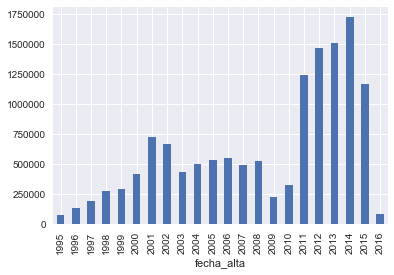

In [69]:
train_ver2["fecha_alta"].groupby([train_ver2["fecha_alta"].dt.year]).count().plot(kind="bar")

The data seems a little unrealistic - the Banco Santander first started in 1857 <https://en.wikipedia.org/wiki/Banco_Santander>, and they can't have picked up the bulk of their customers in 2011 either. I guess the data is more to do with IT systems than reality. However, as the infomation could have some modelling value, and will match the test data, I will keep it, but feed it into models with these issues in mind.

In [70]:
train_ver2['fecha_alta'] = pd.to_numeric(train_ver2['fecha_alta'])

#### ind_nuevo

New customer Index. 1 if the customer registered in the last 6 months.

In [71]:
train_ver2['ind_nuevo'].isnull().sum()

0

In [72]:
train_ver2['ind_nuevo'].value_counts()

0.0    12808211
1.0      811195
Name: ind_nuevo, dtype: int64

The data is clean and logical, let's optimise it into unsigned ints (same footprint as category, but more logical to operate numerically on):

In [73]:
print_memory_size(train_ver2['ind_nuevo'])

207 MB


In [74]:
train_ver2['ind_nuevo'] = pd.to_numeric(train_ver2['ind_nuevo'],downcast='unsigned')

In [75]:
print_memory_size(train_ver2['ind_nuevo'])

116 MB


#### antiguedad

Linked to the above, but hopefully more meaningful, customer seniority in months:

In [76]:
train_ver2['antiguedad'].isnull().sum()

0

In [77]:
train_ver2['antiguedad'].value_counts().head()

0     134334
1     130680
12    130588
3     125788
2     125132
Name: antiguedad, dtype: int64

In [78]:
train_ver2['antiguedad'].value_counts().tail()

255        179
      0    149
256        102
-999999     26
-999999     12
Name: antiguedad, dtype: int64

Two issues here - one some data consistency (if '0' is at the top and bottom), and two the -999999 figures. Let's see if the latter users have a ind_nuevo of zero?

Once again we have the issue of integer numbers being stored as text, and thus not working with numeric filters, and potentially causing various problems. Lets fix this first (optimising space too), then clean the data.

In [79]:
print_memory_size(train_ver2['antiguedad'])

207 MB


In [80]:
train_ver2['antiguedad'] = pd.to_numeric(train_ver2['antiguedad'],downcast='unsigned')

In [81]:
print_memory_size(train_ver2['antiguedad'])

207 MB


In [82]:
train_ver2[(train_ver2['antiguedad']<0) ]['ind_nuevo']

452687      0
461981      0
788786      0
800687      0
1412242     0
1422227     0
2045024     0
2056813     0
2969610     0
2980914     0
3601557     0
3613493     0
4008831     0
4020536     0
5257294     0
5295097     0
5647050     0
5683025     0
6968353     0
6982647     0
7616647     0
7658437     0
8644608     0
8678128     0
9045555     0
9114602     0
10396442    0
10405076    0
10771018    0
11097857    0
11109978    0
11361026    0
11978594    0
12041260    0
12111000    0
12911749    0
12952748    0
12964573    0
Name: ind_nuevo, dtype: uint8

So, looks like all the missing values are new. Let's fix them accordingly:

In [83]:
train_ver2.loc[train_ver2['antiguedad'] <0 , 'antiguedad'] = 0

In [84]:
train_ver2.loc[train_ver2['antiguedad'] == -999999 , 'antiguedad'] = 0

In [85]:
train_ver2['antiguedad'].value_counts().tail()

252    676
253    416
254    261
255    179
256    102
Name: antiguedad, dtype: int64

In [86]:
train_ver2['antiguedad'].describe()

count    1.361941e+07
mean     7.938120e+01
std      6.637407e+01
min      0.000000e+00
25%      2.300000e+01
50%      5.000000e+01
75%      1.350000e+02
max      2.560000e+02
Name: antiguedad, dtype: float64

#### indrel

Is a churn factor, with 99 representing a customer leaving during the month in question:

In [87]:
train_ver2['indrel'].value_counts(dropna=False)

1.0     13594614
99.0       24792
Name: indrel, dtype: int64

All data in place, lets optimise and move on

In [88]:
print_memory_size(train_ver2['indrel'])

207 MB


In [89]:
train_ver2['indrel'] = train_ver2['indrel'].astype('category')

In [90]:
print_memory_size(train_ver2['indrel'])

116 MB


#### ult_fec_cli_1t

If the customer churned, when they churned. It should coordinate with indrel

In [91]:
train_ver2['ult_fec_cli_1t'].isnull().sum()

13594614

The same number as indrel. Let's convert to datetime for later calculation. This column will likely be dropped at the modelling stage, as it'll have little predictive value for age (as it'll have colinearity with the user churning, above) or products (as a churned customer won't buy anything!)

In [92]:
train_ver2['ult_fec_cli_1t'].value_counts(dropna=False).head(5)

NaN           13594614
2015-12-24         763
2015-12-28         521
2015-07-09         443
2015-07-06         405
Name: ult_fec_cli_1t, dtype: int64

In [93]:
print_memory_size(train_ver2['ult_fec_cli_1t'])

207 MB


In [94]:
train_ver2['ult_fec_cli_1t'] = pd.to_datetime(train_ver2['ult_fec_cli_1t'],yearfirst=True)

In [95]:
print_memory_size(train_ver2['ult_fec_cli_1t'])

207 MB


#### indrel_1mes

Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)

In [96]:
train_ver2.indrel_1mes.value_counts(dropna=False)

1.0    7277513
1.0    4017706
1      2195294
NaN     122047
3.0       1804
3.0       1409
3         1137
P          873
2          483
2.0        479
2.0        355
4.0        143
4.0         93
4           70
Name: indrel_1mes, dtype: int64

As the data will be turned into a categorical, I will keep the missing values for completeness sake.

In [97]:
print_memory_size(train_ver2['indrel_1mes'])

207 MB


In [98]:
train_ver2.loc[train_ver2['indrel_1mes'] != 'P','indrel_1mes'] = pd.to_numeric(train_ver2[train_ver2['indrel_1mes'] != 'P']['indrel_1mes'],downcast='unsigned')

In [99]:
train_ver2['indrel_1mes'] = train_ver2['indrel_1mes'].astype('category')

In [100]:
print_memory_size(train_ver2['indrel_1mes'])

116 MB


In [101]:
train_ver2['indrel_1mes'].value_counts(dropna=False)

1.0    13490513
NaN      122047
3.0        4350
2.0        1317
P           873
4.0         306
Name: indrel_1mes, dtype: int64

#### tiprel_1mes

Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential)

In [102]:
print train_ver2['tiprel_1mes'].isnull().sum()
print train_ver2['tiprel_1mes'].value_counts(dropna=False)

122047
I      7304782
A      6187048
NaN     122047
P         4656
R          869
N            4
Name: tiprel_1mes, dtype: int64


Two options here - either go with the most frequent - I, inactive, which makes sense if we are talking about customer relation types, and their date is missing from the IT system!! Second option is to keep the NaN, as their could be meaning in there.

I will go with the former option, as they both essentially equal the same thing I believe.

In [103]:
print_memory_size(train_ver2['tiprel_1mes'])

207 MB


In [104]:
train_ver2['tiprel_1mes'].fillna('I',inplace=True)

In [105]:
train_ver2['tiprel_1mes'] = train_ver2['tiprel_1mes'].astype('category')

In [106]:
print_memory_size(train_ver2['tiprel_1mes'])

116 MB


#### indresi

Residence index (S (Yes) or N (No) if the residence country is the same than the bank country)

In [107]:
print train_ver2['indresi'].isnull().sum()
print train_ver2['indresi'].value_counts(dropna=False)

0
S    13553559
N       65847
Name: indresi, dtype: int64


No missing data. Very few 'N' rows, which stands correct with the earlier stat of under 1% of customers being outside of Spain.

As the data is correct, let's just optimise it down to a category, to be dummied later.

In [108]:
print_memory_size(train_ver2['indresi'])

207 MB


In [109]:
train_ver2['indresi'] = train_ver2['indresi'].astype('category')

In [110]:
print_memory_size(train_ver2['indresi'])

116 MB


#### indext

Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country)

In [111]:
print train_ver2['indext'].isnull().sum()
print train_ver2['indext'].value_counts(dropna=False)

0
N    12974670
S      644736
Name: indext, dtype: int64


Data looks complete, and, logical (~5% is beliable). Let's optimise into a category

In [112]:
print_memory_size(train_ver2['indext'])

207 MB


In [113]:
train_ver2['indext'] = train_ver2['indext'].astype('category')

In [114]:
print_memory_size(train_ver2['indext'])

116 MB


#### conyuemp

Spouse index. 1 if the customer is spouse of an employee

In [115]:
print train_ver2['conyuemp'].isnull().sum()
print train_ver2['conyuemp'].value_counts(dropna=False)

13617598
NaN    13617598
N          1791
S            17
Name: conyuemp, dtype: int64


So, here we have a data issue - it is unclear if the 'N' values should be 1s - customers with employees as spouses, or, if S should be the 1 value. Even if both were the case, it would only represent

In [116]:
print train_ver2['conyuemp'].notnull().sum()/float(train_ver2['conyuemp'].value_counts(dropna=False).sum())

0.000132751751435


A one hundreth of a percent of the data. As the data is likely inaccurate, or at risk of being interpreted inaccurately by me, it creates a risk of the model.

Perhaps if the data wasn't anonymised, we could confirm each row using names and addresses and sequences of ID numbers, but, we do not have that data.

Given this I will remove the column.

In [117]:
print_memory_size(train_ver2['conyuemp'])

207 MB


In [118]:
train_ver2.drop('conyuemp',inplace=True,axis=1)

#### canal_entrada

Channel used by the customer to join

In [119]:
print train_ver2['canal_entrada'].isnull().sum()

print train_ver2['canal_entrada'].value_counts(dropna=False).shape[0]
print train_ver2['canal_entrada'].value_counts(dropna=False).head(10)
print train_ver2['canal_entrada'].value_counts(dropna=False).tail()

158391
163
KHE    4055270
KAT    3268180
KFC    3098301
KHQ     591039
KFA     409669
KHK     241084
KHM     183924
NaN     158391
KHD     116891
KHN     116608
Name: canal_entrada, dtype: int64
KDB    17
KDL    11
025    11
KHS     5
KHR     1
Name: canal_entrada, dtype: int64


The data is nearly complete, although, missing info would be in the top 10 as a category. Also, we have no context for what each of the customer channel codes means. Because there are 162 different channels, it'll likely have to be reduced at a later stage when dummied, but for now I will keep the NaN values, to be sectioned when dummying.

In [120]:
print_memory_size(train_ver2['canal_entrada'])

207 MB


In [121]:
train_ver2['canal_entrada'] = train_ver2['canal_entrada'].astype('category')

In [122]:
print_memory_size(train_ver2['canal_entrada'])

129 MB


#### indfall

Deceased index. Expected values of N/S

In [123]:
print train_ver2['indfall'].isnull().sum()
print train_ver2['indfall'].value_counts(dropna=False)

0
N    13584649
S       34757
Name: indfall, dtype: int64


The data is complete, and just needs to be optimised. At a later stage we will deal with the business recomendations to make sure customer recomendations and marketing is not sent to the deceased.

In [124]:
print_memory_size(train_ver2['indfall'])

207 MB


In [125]:
train_ver2['indfall'] = train_ver2['indfall'].astype('category')

In [126]:
print_memory_size(train_ver2['indfall'])

116 MB


#### tipodom

Address type, with 1 donating primary address. 

In [127]:
print train_ver2['tipodom'].isnull().sum()
print train_ver2['tipodom'].value_counts(dropna=False)

1
 1.0    13619405
NaN            1
Name: tipodom, dtype: int64


There is essentially no distinction, or modelling value in the data. Presumably the IT system has detailed alternate address information, which could have been useful (indicating multiple house ownership etc, or an out of state student), but, it was presumably lost in the anonymisation process. This column will thus be removed.

In [128]:
print_memory_size(train_ver2['tipodom'])

207 MB


In [129]:
train_ver2.drop('tipodom',inplace=True,axis=1)

#### cod_prov

Province code (customer's address)

In [130]:
print train_ver2['cod_prov'].isnull().sum()
print train_ver2['cod_prov'].value_counts(dropna=False).head()

65857
28.0    4409532
8.0     1275208
46.0     682304
41.0     605164
15.0     429322
Name: cod_prov, dtype: int64


This code links with precisely with the nomprov (name of Province) feature below. The name value is far more human readable for the same data, so I will drop this field to clean up the features.

In [131]:
print_memory_size(train_ver2['cod_prov'])

207 MB


In [132]:
train_ver2.drop('cod_prov',inplace=True,axis=1)

#### nomprov

Province name

In [133]:
print train_ver2['nomprov'].isnull().sum()
print len(train_ver2['nomprov'].value_counts(dropna=False).index)
print train_ver2['nomprov'].value_counts(dropna=False).head()

65857
53
MADRID       4409532
BARCELONA    1275208
VALENCIA      682304
SEVILLA       605164
CORUÑA, A     429322
Name: nomprov, dtype: int64


Three issues here:
One that 65857 fields are missing data (around half a percent).
Two the risk of text processing issues with the 'CORUÑA, A' users.
Three Wikipedia says there are 50 provinces of Spain (https://en.wikipedia.org/wiki/Provinces_of_Spain), so the 52/53 number is perculiar. Comparing the value counts of nomprov to the Wikipedia article, the areas missing in Wikipedia are Ceuta and Mellilla, which are both automonous cities, and differ in categorisation depending on the source. This mismatch is not a data issue though in terms of feeding the models.

On the missing data, I without the data stripped out of the dataset to anonymise it, there is no way of imputing it. I will replace it with an 'unknown' value 'desconocido'

In [134]:
train_ver2['nomprov'].fillna('DESCONOCIDO',inplace=True)

In [135]:
print_memory_size(train_ver2['nomprov'])

207 MB


In [136]:
train_ver2['nomprov'] = train_ver2['nomprov'].astype('category')

In [137]:
print_memory_size(train_ver2['nomprov'])

116 MB


#### ind_actividad_cliente

Activity index (1, active customer; 0, inactive customer)

In [138]:
print train_ver2['ind_actividad_cliente'].isnull().sum()
print train_ver2['ind_actividad_cliente'].value_counts(dropna=False)

0
0.0    7384311
1.0    6235095
Name: ind_actividad_cliente, dtype: int64


Customer activity is complete, and almost split down the middle. It should be interesting for product prediction.

In [139]:
print_memory_size(train_ver2['ind_actividad_cliente'])

207 MB


In [140]:
train_ver2['ind_actividad_cliente'] = train_ver2['ind_actividad_cliente'].astype('category')

In [141]:
print_memory_size(train_ver2['ind_actividad_cliente'])

116 MB


#### renta

Gross income of the household

In [142]:
print train_ver2['renta'].isnull().sum()
print train_ver2['renta'].notnull().sum()
print train_ver2['renta'].isnull().sum()/float(train_ver2.shape[0])

print train_ver2['renta'].value_counts(dropna=False).head()

2766589
10852817
0.203135804895
NaN           2766589
 451931.22       5582
 463625.16       1743
 181042.20       1493
 128318.52       1404
Name: renta, dtype: int64


So, we see 20% of gross annual household incomes are missing. We can't remove 20% of the data, and I assume the test data could also have missing values, so we need a way to impute the missing values.

The spanish economy is complex, and varies substantially on a regional basis <https://en.wikipedia.org/wiki/Ranked_lists_of_Spanish_autonomous_communities#GRP_.28PPP.29_per_capita_per_euro>. So lets check the mean renta per province:

| # 	| Autonomous community 	| Euro (2012)[7] 	| Percentage difference from the national average[7] 	| Comparable country 	|
|----	|----------------------	|----------------	|----------------------------------------------------	|--------------------	|
| 1 	| Basque Country 	| 30,829 	| 35.4 	| Germany 	|
| 2 	| Madrid 	| 29,385 	| 29 	| Iceland 	|
| 3 	| Navarre 	| 29,071 	| 27.7 	| Belgium 	|
| 4 	| Catalonia 	| 27,248 	| 19.7 	| France 	|
| 5 	| Aragon 	| 25,540 	| 12.2 	| Japan 	|
| 6 	| La Rioja 	| 25,508 	| 12 	| Japan 	|
| 7 	| Balearic Islands 	| 24,393 	| 7.1 	| Italy 	|
| 8 	| Cantabria 	| 22,341 	| −1.9 	| Malta 	|
| 9 	| Castile and León 	| 22,289 	| −2.1 	| Israel 	|
| 10 	| Asturias 	| 21,035 	| −7.6 	| Cyprus 	|
| 11 	| Galicia 	| 20,723 	| −9.0 	| Cyprus 	|
| 12 	| Valencian Community 	| 19,964 	| −12.3 	| Slovenia 	|
| 13 	| Canary Islands 	| 19,568 	| −14.1 	| Slovenia 	|
| 14 	| Ceuta 	| 19,335 	| −15.1 	| Slovakia 	|
| 15 	| Region of Murcia 	| 18,520 	| −18.7 	| Lithuania 	|
| 16 	| Castile–La Mancha 	| 17,698 	| −22.3 	| Greece 	|
| 17 	| Melilla 	| 16,981 	| −25.4 	| Poland 	|
| 18 	| Andalusia 	| 16,960 	| −25.5 	| Poland 	|
| 19 	| Extremadura 	| 15,394 	| −32.4 	| Argentina 	|

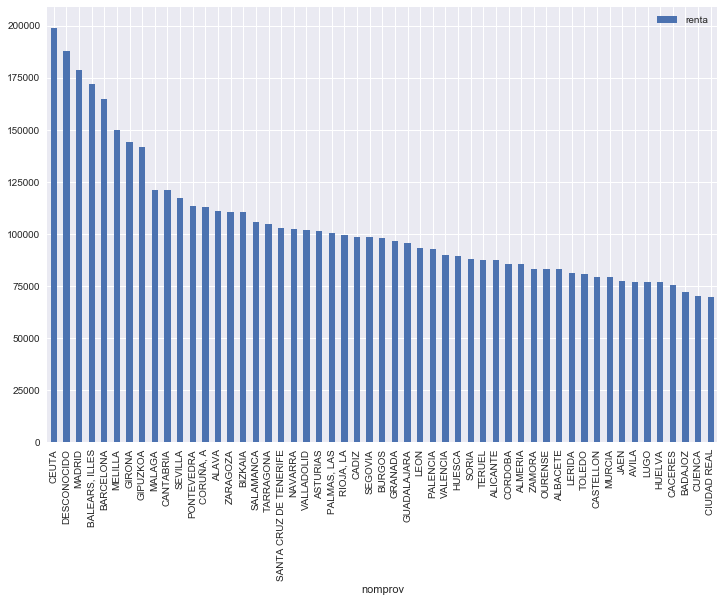

In [143]:
pd.pivot_table(train_ver2,index='nomprov',values='renta',dropna=True).sort_values(by='renta',ascending=False).plot(kind='bar',figsize=(12, 8))

This will go a substanial way to accurately predict the missing values. If there is substantial difficulty on this column in the future, I will come back and perhaps use a model (logistic regression, knn regression, or perhaps decision tree based) for additional accuracy, because income, and product choices, are likely to be highly correlated.

This exercise gave me a very good lesson in optimising code, especially on large datasets, to work in a more pythonic way. My original attempt to propogate the imputed median incomes per region was to do so on a line by line basis, looping through the data frame. Due to the inefficiencies of the code though, it took over 10 minutes to complete the 13 million loops, as shown by the printed times:

In [ ]:
"""
# determine mean rento based on geography
median_rentas = train_ver2.groupby('nomprov')['renta'].median()
#NA groups in GroupBy are automatically excluded. This behavior is consistent with R, for example:
#http://pandas.pydata.org/pandas-docs/stable/missing_data.html#na-values-in-groupby

now = datetime.now()
print now


temp_renta = train_ver2[['nomprov','renta']]

def impute_missing_rentas(row):
    if pd.isnull(row['renta']):
        return median_rentas.loc[row['nomprov']]
    else:
        return row['renta']

train_ver2['renta'] = temp_renta.apply(impute_missing_rentas,axis=1)

print datetime.now()
print datetime.now() - now


#OUTPUT: 


#2017-05-20 18:40:09.126739
#2017-05-20 18:50:22.138145
#0:10:13.011598

"""

Instead, I ran a more pythonic method, designed to work with the heavily optimised dataframe structure. The code became four steps. Firstly, create a dataframe of the median income per province:

In [145]:
now = datetime.now()
print now

renta_per_region = pd.DataFrame(train_ver2.groupby('nomprov')['renta'].median())
print renta_per_region.head()

2017-05-25 20:20:04.572748
             renta
nomprov           
ALAVA     96967.65
ALBACETE  78657.30
ALICANTE  67526.28
ALMERIA   73390.65
ASTURIAS  87199.38


Then to create a dataframe of the rows missing an income, and their provinces:

In [146]:
missing_renta = pd.DataFrame(train_ver2[train_ver2.renta.isnull()]['nomprov'])

Next, to merge the two prior steps, so the imputed missing values are in order:

In [147]:
missing_renta = pd.merge(missing_renta,renta_per_region,how='left',left_on='nomprov',right_index=True)['renta']

Then finally to update the rows with missing data in the main dataframe with the new values:

In [148]:

train_ver2['renta'].fillna(missing_renta,inplace=True)

print datetime.now()
print datetime.now() - now

2017-05-25 20:20:07.004520
0:00:02.431935


The code time improvement was dramatic - from 10 minutes down to a couple of seconds. This means method could be used on a much bigger dataset. By working with larger data sets, bad coding practises that modern hardware can hide on smaller projects, are revealed! I appreciate this method is far from perfect though, and will have to continue to learn in order to deal with datasets orders of magnitudes larger!

In [149]:
train_ver2['renta'].isnull().sum()

0

The data has been imputed and cleaned, with no missing values. As the numbers are already stored as floats, there is no memory improvement to any conversion method.

#### segmento

segmentation: 01 - VIP, 02 - Individuals 03 - college graduated

In [150]:
print train_ver2['segmento'].isnull().sum()
print train_ver2['segmento'].value_counts(dropna=False)

161633
02 - PARTICULARES     7960052
03 - UNIVERSITARIO    4935579
01 - TOP               562142
NaN                    161633
Name: segmento, dtype: int64


We do have some missing values to contend with, in the data.

To start, lets have a look at the age distribution of the missing customers:

[]

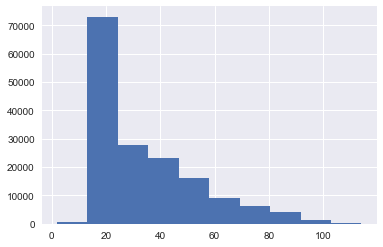

In [151]:
train_ver2[train_ver2['segmento'].isnull()]['age'].hist().plot()

So, the missing ~1% skews younger than the overall customer base, with a single mode and a positive skew. However, without the missing data personal we cannot determine, or predict, if the users are University students or not, so lets apply the common value to missing values.

In [152]:
train_ver2['segmento'].fillna('02 - PARTICULARES',inplace=True)

In [153]:
print_memory_size(train_ver2['segmento'])

207 MB


In [154]:
train_ver2['segmento'] = train_ver2['segmento'].astype('category')

In [155]:
print_memory_size(train_ver2['segmento'])

116 MB


With all customer information columns imputed, lets check again for missing values:

In [156]:
customer_columns = []
for column in train_ver2.columns:
    if 'ind_' not in column and '_ult1' not in column:
        customer_columns.append(column)
        

In [157]:
for column in customer_columns:
    if train_ver2[column].isnull().sum() > 0:
        print column, train_ver2[column].isnull().sum()

ult_fec_cli_1t 13594614
indrel_1mes 122047
canal_entrada 158391


So, the only three columns with missing values remaining are features where the NaN will be maintained, and dummied later.

---

#### Product Columns

Now, lets check out the product columns, which *should* be simple binary - 1 for the customer having the product that month, 0 if they don't'.

In [158]:
product_columns = []
for column in train_ver2.columns:
    if 'ind_' in column and '_ult1' in column:
        product_columns.append(column)
print product_columns

['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']


In [159]:
for column in product_columns:
    print column
    print train_ver2[column].value_counts(dropna=False)

ind_ahor_fin_ult1
0    13618010
1        1396
Name: ind_ahor_fin_ult1, dtype: int64
ind_aval_fin_ult1
0    13619090
1         316
Name: ind_aval_fin_ult1, dtype: int64
ind_cco_fin_ult1
1    8938089
0    4681317
Name: ind_cco_fin_ult1, dtype: int64
ind_cder_fin_ult1
0    13614034
1        5372
Name: ind_cder_fin_ult1, dtype: int64
ind_cno_fin_ult1
0    12516390
1     1103016
Name: ind_cno_fin_ult1, dtype: int64
ind_ctju_fin_ult1
0    13490357
1      129049
Name: ind_ctju_fin_ult1, dtype: int64
ind_ctma_fin_ult1
0    13487152
1      132254
Name: ind_ctma_fin_ult1, dtype: int64
ind_ctop_fin_ult1
0    11860067
1     1759339
Name: ind_ctop_fin_ult1, dtype: int64
ind_ctpp_fin_ult1
0    13028755
1      590651
Name: ind_ctpp_fin_ult1, dtype: int64
ind_deco_fin_ult1
0    13595573
1       23833
Name: ind_deco_fin_ult1, dtype: int64
ind_deme_fin_ult1
0    13596743
1       22663
Name: ind_deme_fin_ult1, dtype: int64
ind_dela_fin_ult1
0    13033190
1      586216
Name: ind_dela_fin_ult1, dtype: int6

So, it is looking pretty good - only two columns have NaN values, which will be zero'd - one must assume a bank has *very* detailed records of banking products, so they can keep the customers money safe (and charge them).
The second step will be to change the integers to categories to reduce footprint, which should be a substantial saving.

In [160]:
train_ver2[product_columns].isnull().sum()

ind_ahor_fin_ult1      0
ind_aval_fin_ult1      0
ind_cco_fin_ult1       0
ind_cder_fin_ult1      0
ind_cno_fin_ult1       0
ind_ctju_fin_ult1      0
ind_ctma_fin_ult1      0
ind_ctop_fin_ult1      0
ind_ctpp_fin_ult1      0
ind_deco_fin_ult1      0
ind_deme_fin_ult1      0
ind_dela_fin_ult1      0
ind_ecue_fin_ult1      0
ind_fond_fin_ult1      0
ind_hip_fin_ult1       0
ind_plan_fin_ult1      0
ind_pres_fin_ult1      0
ind_reca_fin_ult1      0
ind_tjcr_fin_ult1      0
ind_valo_fin_ult1      0
ind_viv_fin_ult1       0
ind_nomina_ult1      217
ind_nom_pens_ult1    217
ind_recibo_ult1        0
dtype: int64

The code to fill in the zeros in the two columns:

In [161]:
train_ver2.loc[:,'ind_nomina_ult1'].fillna(0, inplace=True)
train_ver2.loc[:,'ind_nom_pens_ult1'].fillna(0, inplace=True)

And lets check the memory footprint of the file:

In [162]:
train_ver2[product_columns].memory_usage().sum()/(1024**2), "MB"

(2597, 'MB')

Over 2GB! Approximately half the original footprint. Lets see what improvement can be made by converting the int64s to unsigned integers (not categories, as it introduces complexities on numerical operations):

In [163]:
for col in product_columns:
    train_ver2[col] = pd.to_numeric(train_ver2[col],downcast='unsigned')

In [164]:
train_ver2[product_columns].memory_usage().sum()/(1024**2), "MB"

(415, 'MB')

An >80% improvement! Lets see what the dataframe comes in at now?

In [165]:
train_ver2.memory_usage().sum()/(1024**2), "MB"

(1194, 'MB')

We are just under a gigabyte, meaning an 80% reduction on the original memory footprint.

![Mac OS X Activity Monitor, Python2.7, 2.4GB](assets/reduced_memory_footprint.png "Down to 2.4GB Memory footprint on the unprocessed dataframe, before calculations")

There is a corresponding decrease in the system level memory impact of python too.

Although my personal computers have 16GB and 32GB of RAM respectively, without optimisation, a computer with 8GB would struggle to keep the original dataframe in RAM, so these improvements would help collaborate with others.

Secondly, the theory used will help when dealing with larger datasets, hitting the RAM ceiling of my machine and future work machines. Being able to work with 4 to 5 times more data in RAM is going to help on future projects.

The memory improvements should also mean speed improvements, and perhaps the use of more complex models, which make cuts and super samples and copies of the data.

The next step is to write the cleaned file to a seperate CSV, so it doesn't have to be re-processed each time, a process which takes over 10 minutes, the first 75 seconds of the process is the pandas read_csv function, which will remain approximately the same.

In [166]:
train_ver2.to_csv("../../../../capstone_assets/df_age.csv")

# Baseline Recalibration

Now that the age has been cleaned slightly, let's quickly re-calculate the baseline ages:

In [167]:
print "Initial Median age  : ",age_median
print "Initial Mean age    : ",age_mean

print "Initial Root mean squared error of a median baseline : ", np.mean((ages-age_median)**2)**0.5
print "Initial Root mean squared error of a mean baseline   : ", np.mean((ages-age_mean)**2)**0.5

Initial Median age  :  39.0
Initial Mean age    :  40.1814649136
Initial Root mean squared error of a median baseline :  17.2256509829
Initial Root mean squared error of a mean baseline   :  17.1850863379


In [168]:
print "New Median age  : ",np.median(train_ver2.age)
print "New Mean age    : ",np.mean(train_ver2.age)
print "New Root mean squared error of a median baseline : ", np.mean((train_ver2.age-np.median(train_ver2.age))**2)**0.5
print "New Root mean squared error of a mean baseline   : ", np.mean((train_ver2.age-np.mean(train_ver2.age))**2)**0.5

New Median age  :  39.0
New Mean age    :  40.1808542898
New Root mean squared error of a median baseline :  17.2241347305
New Root mean squared error of a mean baseline   :  17.183608479


The cleaning of the data had no effective change on the age baseline.

A question mark remains as to whether the cleaned data will be a more, or less, effective trainer for product prediction. Some models, such as certain decision trees, can accept and model on missing values. I will consider modelling, adding the missing data, if there is potentially value. I will also have to consider how the test data is treated - if it is also cleaned, or if the future month's products are soley predicted from the previous month(s) data in this data frame.

# Parse: Create a Data Dictionary	

Because this project originates from a Kaggle, a clear data dictionary is already provided with the file:

<https://www.kaggle.com/c/santander-product-recommendation/data>

| Column Name 	| Description 	|
|-----------------------	|---------------------------------------------------------------------------------------------------------------------------------------------	|
| fecha_dato 	| The table is partitioned for this column 	|
| ncodpers 	| Customer code 	|
| ind_empleado 	| Employee index: A active, B ex employed, F filial, N not employee, P pasive 	|
| pais_residencia 	| Customer's Country residence 	|
| sexo 	| Customer's sex 	|
| age 	| Age 	|
| fecha_alta 	| The date in which the customer became as the first holder of a contract in the bank 	|
| ind_nuevo 	| New customer Index. 1 if the customer registered in the last 6 months. 	|
| antiguedad 	| Customer seniority (in months) 	|
| indrel 	| 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month) 	|
| ult_fec_cli_1t 	| Last date as primary customer (if he isn't at the end of the month) 	|
| indrel_1mes 	| Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner) 	|
| tiprel_1mes 	| Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential) 	|
| indresi 	| Residence index (S (Yes) or N (No) if the residence country is the same than the bank country) 	|
| indext 	| Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country) 	|
| conyuemp 	| Spouse index. 1 if the customer is spouse of an employee 	|
| canal_entrada 	| channel used by the customer to join 	|
| indfall 	| Deceased index. N/S 	|
| tipodom 	| Addres type. 1, primary address 	|
| cod_prov 	| Province code (customer's address) 	|
| nomprov 	| Province name 	|
| ind_actividad_cliente 	| Activity index (1, active customer; 0, inactive customer) 	|
| renta 	| Gross income of the household 	|
| segmento 	| segmentation: 01 - VIP, 02 - Individuals 03 - college graduated 	|
| ind_ahor_fin_ult1 	| Saving Account 	|
| ind_aval_fin_ult1 	| Guarantees 	|
| ind_cco_fin_ult1 	| Current Accounts 	|
| ind_cder_fin_ult1 	| Derivada Account 	|
| ind_cno_fin_ult1 	| Payroll Account 	|
| ind_ctju_fin_ult1 	| Junior Account 	|
| ind_ctma_fin_ult1 	| Más particular Account 	|
| ind_ctop_fin_ult1 	| particular Account 	|
| ind_ctpp_fin_ult1 	| particular Plus Account 	|
| ind_deco_fin_ult1 	| Short-term deposits 	|
| ind_deme_fin_ult1 	| Medium-term deposits 	|
| ind_dela_fin_ult1 	| Long-term deposits 	|
| ind_ecue_fin_ult1 	| e-account 	|
| ind_fond_fin_ult1 	| Funds 	|
| ind_hip_fin_ult1 	| Mortgage 	|
| ind_plan_fin_ult1 	| Pensions 	|
| ind_pres_fin_ult1 	| Loans 	|
| ind_reca_fin_ult1 	| Taxes 	|
| ind_tjcr_fin_ult1 	| Credit Card 	|
| ind_valo_fin_ult1 	| Securities 	|
| ind_viv_fin_ult1 	| Home Account 	|
| ind_nomina_ult1 	| Payroll 	|
| ind_nom_pens_ult1 	| Pensions 	|
| ind_recibo_ult1 	| Direct Debit 	|

The first 24 columns are regarding the data itself (e.g. the month captured) and the customer.

Products columns are prefaced with 'ind_' and prefixed with '_ult1' - the latter 24 columns.

The order and naming of the columns is consistent across the imported CSV, the dataframe, the exported CSV, and the predictions exported to Kaggle.

For the duration of the project, I will maintain the Spanish feature names. When working in international businesses previously, it was always important to maintain native language feature names, or else interoperability became confused. By maintaining the Spanish names, the work will be understood by the Kaggle grading system, the fictional end customer, and one of the two graders of the project. However, for final presentation, the feature names could be translated into English, if required by the shape of the presentation format.

# Mine: Perform & summarize EDA 

Because of the nature of the dataset - one line per customer per month, over a period per customer of up to 17 months, there is both a lot of subtle and important changes in the file - product changes month to month will be extremely important in the prediction model, but, it complicates initial EDA through the duplication.

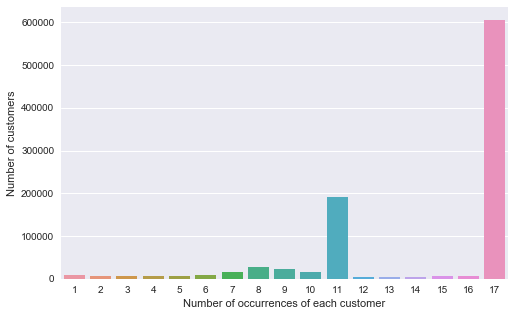

In [169]:
customer_count = train_ver2.groupby('ncodpers').agg('size').value_counts()
plt.figure(figsize=(8,5))
sns.barplot(customer_count.index,customer_count.values)
plt.xlabel('Number of occurrences of each customer')
plt.ylabel('Number of customers');

In [170]:
train_ver2.shape

(13619406, 45)

_(Here we see the majority of customers being referenced 17 times each, with another set having 11 entries, which must be down to how Santander collected, generated and anonymised the data. Customers outside those two periods could have interesting properties to study)_

To get around this, a simplified dataset will be created for much of the first pass of EDA - one line per customer, on the final month of their recorded activity. This will allow high level EDA based without complex dataset grouping and pivoting. The original dataframe will also be used to track monthly evolutions.

In [171]:
df_age = train_ver2.sort_values(by='fecha_dato').drop_duplicates(subset='ncodpers', keep='last')
# a reduced dataframe, taking the last entry of each customer (via their ID, and sorted by the data's date)

In [172]:
print train_ver2.shape
print df_age.shape

(13619406, 45)
(949604, 45)


The data has been shrunk down to under a million rows, with the same feature set.

### Age

As age is at the heart of the first part of the project, lets dive into the details. First, the distribution of ages:

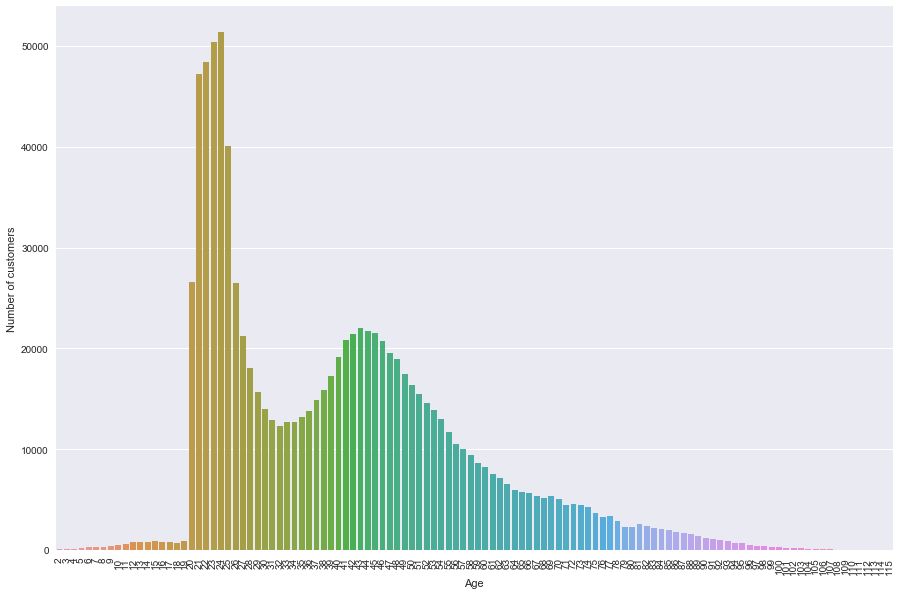

In [173]:
age_count = df_age['age'].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(age_count.index,age_count.values.astype(int))
plt.xticks(rotation='vertical')
plt.xlabel('Age')
plt.ylabel('Number of customers')

The age distribution appears bimodal - with a steep spike between 20 and 21 years, peaking at 24.. It then decreases with a similiar slope, reaching a minima at 32, then raising slowly back up to 43. It then curves slowly down.

This will reflect the success, and failure, of the bank's marketing campaign - with a very strong campaign aimed at university students, who must churn to other banks as they graduate. We will see customers returning in their mid to late thirties, presumably driven by both spending and saving related products.

#### Peer review follow up

Following up with the Capstone group peer review process, Ali Gluez <https://twitter.com/Aligulez> proposed researching the business more to understand it's goals, which in turn influence the customers, and thus the modelling. Santander's corporate website is extremely clear about their strategy of University integration - <http://www.santander.com/csgs/Satellite/CFWCSancomQP01/en_GB/Corporate/Sustainability/Santander-Universities-/Santander-committed-to-Higher-Education.html> <http://www.gruposantander.es/univ_espaya.html>. Santander have ties with 124 Spanish Universities and research centres. As there are only 76 formal universities in Spain <https://en.wikipedia.org/wiki/Higher_education_in_Spain> this means Santander effectively has ties with all of them.

Taking this further, and talking to Paco Casanueva, who was both a Spanish University student and Santander Employee, he confirmed the university integration is key. They actively recruit new customers on campus at the start of each year, and importantly have branches on campus, which is important for the disproportionately cash based student customers. After graduation, competitor banks market to graduates, with cheaper products, which explains the mode around 20 years old.

The second mode in the late fourties is then tied to Santander's dominance in mortgages, pensions and family accounts, all of which are reflected in the product data of the project.

The interconnection between age, churn and products will be crucial to the project, as it'll influence the prediction of age, and the prediction of future products.

From a business perspective, further insight into customer product evolution might help maintain, and grow, customer numbers through stronger, more relevant marketing.

In [174]:
age_group = (df_age.groupby(pd.cut(df_age['age'], [0,25,45,65,85,105, pd.np.inf], right=False)).sum())
age_group = age_group.loc[:,product_columns]

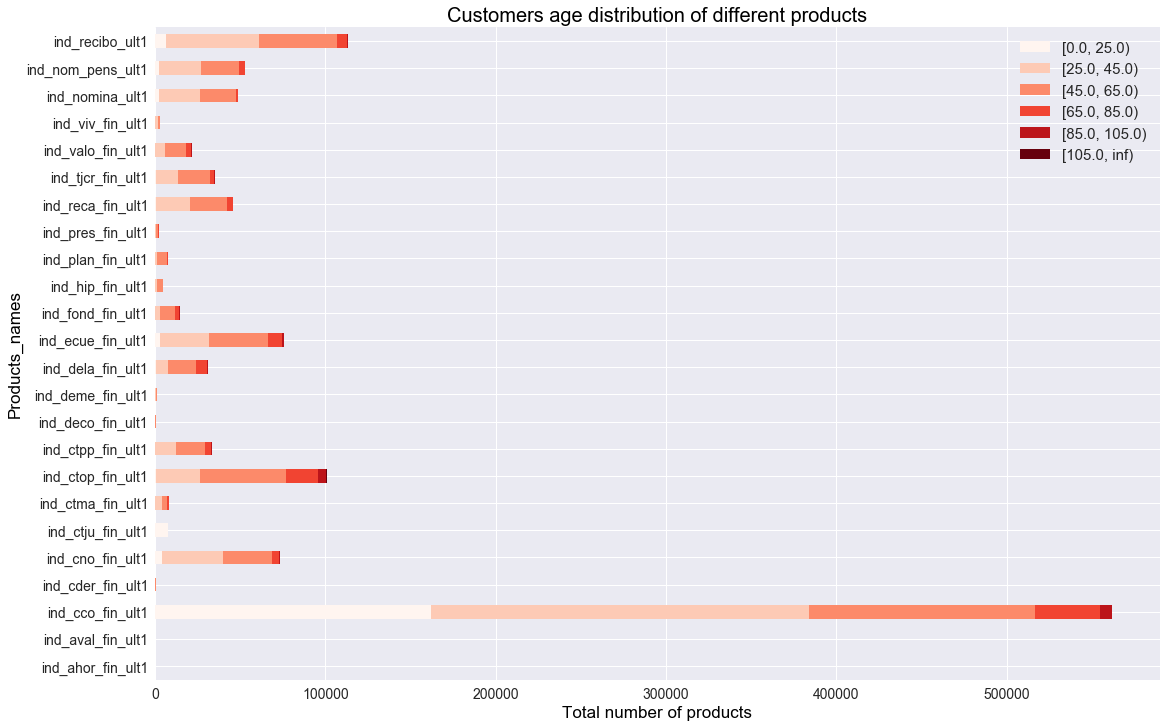

In [175]:
age_group = age_group.T
age_group.plot(kind='barh', stacked=True, fontsize=14, figsize=[18,12], colormap='Reds')
plt.title('Customers age distribution of different products', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(prop={'size':15}, loc=1) 

In [176]:
product_columns_excluding_current = product_columns
product_columns_excluding_current.remove('ind_cco_fin_ult1')

If we remove the current account, we can get a better look at the breakdown:

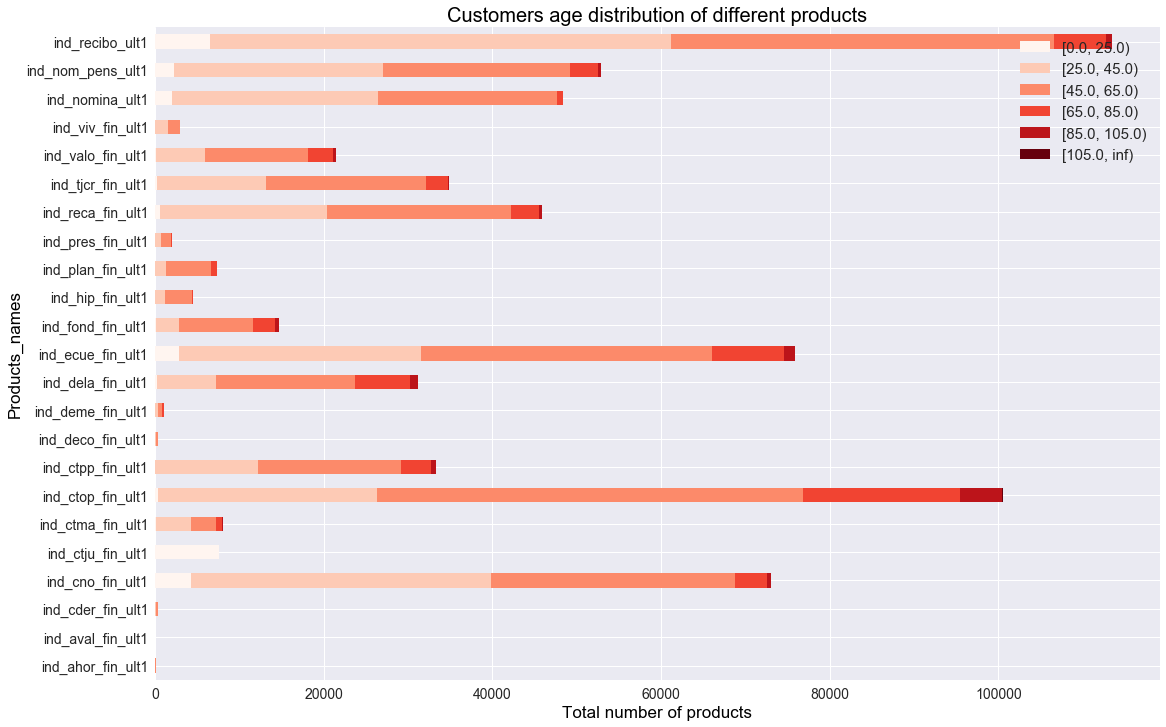

In [177]:
age_group.loc[product_columns_excluding_current,:].plot(kind='barh', stacked=True, fontsize=14, figsize=[18,12], colormap='Reds')
plt.title('Customers age distribution of different products', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(prop={'size':15}, loc=1) 

We start to see exactly the high level picture you would expect, including:
* 0 to 25 exclusively covering the Junior Account (ctju_fin_ult)
* The youth also over indexing on Direct Debit (recibo), payroll payment (nomina), e-accounts (ecue), and payroll account (cno_fin).
* On the other end of the spectrum, we see the two darkest colours - 85 onward, over represented in the ctop account, which links to a method of none direct payments (e.g. pensions), and securities (valo_fin).
* reca-fin pertains to taxes, and is dominated by 25 to 65 - the product many customers come back to Santander to use.

The bands were set wide to be visually interpretable, but there is lots in here to suggest there should be modelling accuracy to be gained by looking at product ownership when modelling for age.

Another way to model this is to look at the age boxplots per product, comparing the age range of people who do not have it, with the ages of those that do. We should we similiar patterns as above, but with a little more detail:

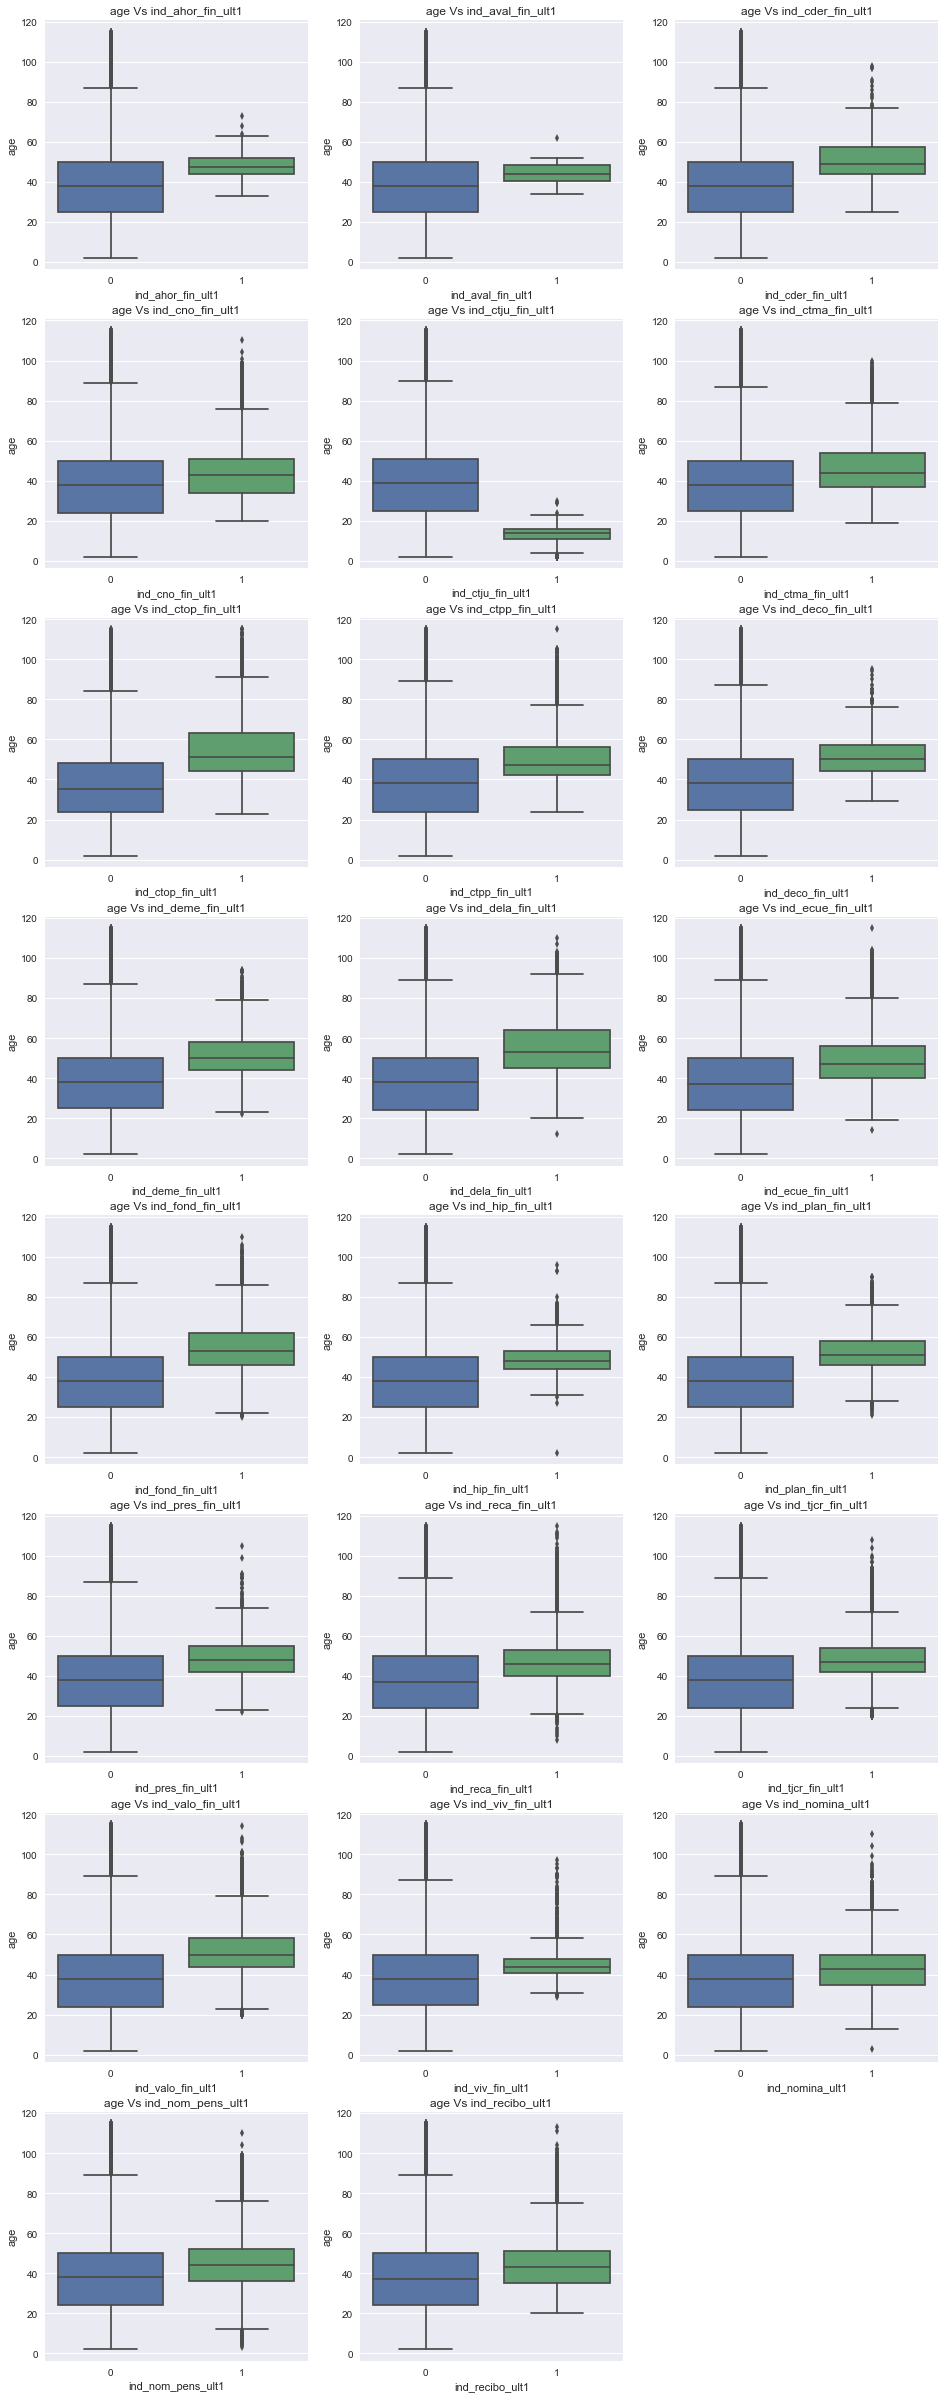

In [178]:
fig = plt.figure(figsize=(16, 120))
plot_count = 0
for index, plot in enumerate(product_columns):
    plot_count += 1
    plt.subplot(22, 3, plot_count)
    sns.boxplot(x=plot, y='age', data=df_age)
    plt.title('age'+" Vs "+plot)
plt.show()

For another dimension, lets check average product ownership per age range:

In [179]:
df_age["total_products"] = df_age.loc[:,product_columns].sum(axis=1)
df_age["total_products"]   = pd.to_numeric(df_age["total_products"], errors="coerce") 


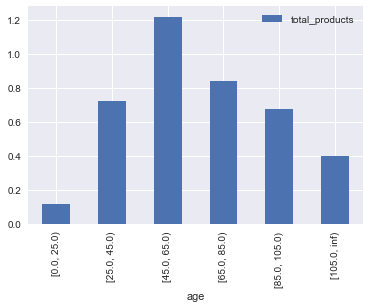

In [180]:
df_age[['total_products']].groupby(pd.cut(df_age['age'],
                                    [0,25,45,65,85,105, pd.np.inf], right=False)).mean().plot(kind='bar')

This again supports the idea of a burst of banking activity in the 30's and 40's, which both brings customers back to the bank, but also helps indicate their age.

However, customers averaging below 1 product seems pretty unexpected - lets visualise the customer status variable 'tiprel_1mes'

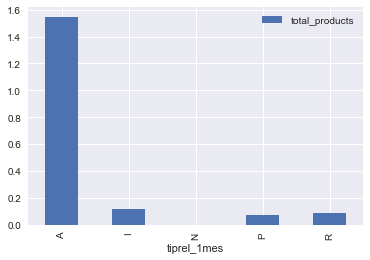

In [181]:
df_age[['total_products','tiprel_1mes']].groupby(by='tiprel_1mes').mean().plot(kind='bar')

_Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential)_

So, we see active customers with higher product averages, and inactive customers with lower averages. This isn't a surpise, but it is important to understand the scale of inactive cutomers in the dataset :

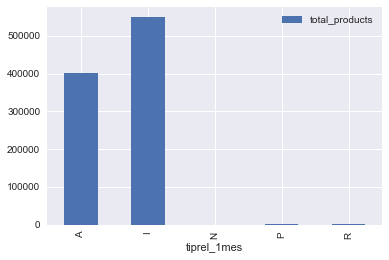

In [182]:
df_age[['total_products','tiprel_1mes']].groupby(by='tiprel_1mes').count().plot(kind='bar')

So, the majority of customers in the dataset are inactive. This will impact the project a lot - inactive customers will give far less signals, thus less scope to model, in terms of both age and next product. This is a dangerous circle, but potentially with correctly applied Data Science and marketing it could be broken!

As this project is largely centred around marketing, lets check the channels bringing in the customers:

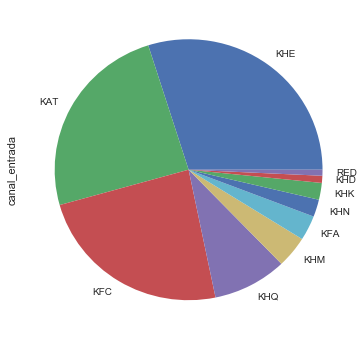

In [183]:
df_age['canal_entrada'].value_counts().head(10).plot(kind='pie',figsize=[6,6]);

Three particular channels dominate. It'll be interesting to dive deeper into how they connect to product migrations, but right now let's see how they link to age:

In [184]:
print 'KHQ attracted customers average age: ',df_age[df_age['canal_entrada']=='KHQ']['age'].mean()
print 'KHE attracted customers average age: ',df_age[df_age['canal_entrada']=='KHE']['age'].mean()
print 'KFC attracted customers average age: ',df_age[df_age['canal_entrada']=='KFC']['age'].mean()
print 'KAT attracted customers average age: ',df_age[df_age['canal_entrada']=='KAT']['age'].mean()

KHQ attracted customers average age:  22.5544024456
KHE attracted customers average age:  25.8718022352
KFC attracted customers average age:  46.1208805825
KAT attracted customers average age:  51.844205333


This is a great finding. It is logical - particular channels are used to attract particular customers, but it should have a strong effect on our age predictions

Another element which might link to age is customer seniority - antiguedad. Lets see if there is a link?

In [185]:
df_age[['age','antiguedad']].corr()

,age,antiguedad
age,1.000000,0.585992
antiguedad,0.585992,1.000000


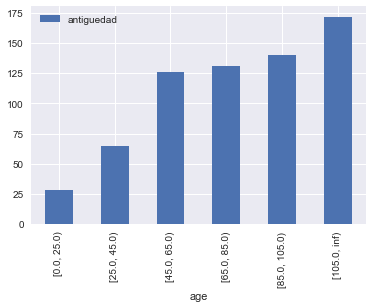

In [186]:
df_age[['antiguedad']].groupby(pd.cut(df_age['age'],[0,25,45,65,85,105, pd.np.inf], right=False)).mean().plot(kind='bar')

This looks like it could be another good age estimator for the first modal peak.

What about the age per provence?

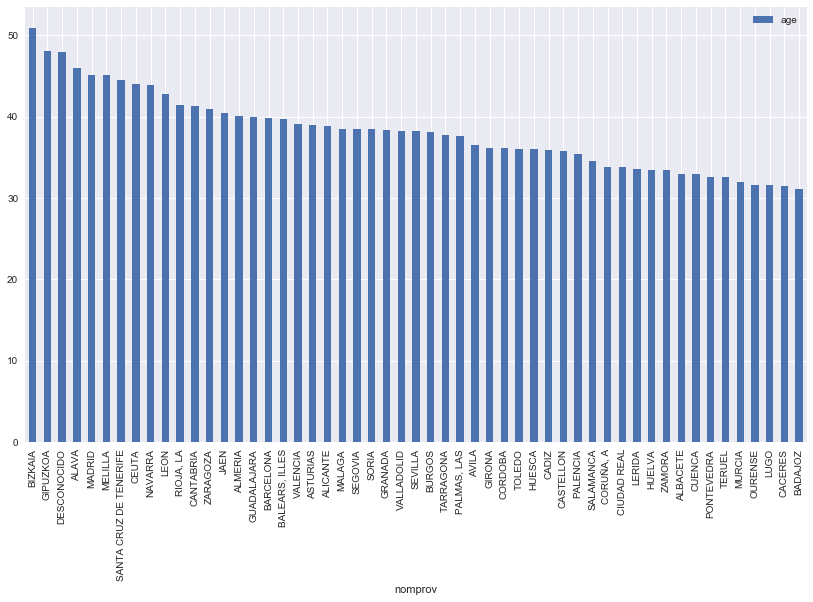

In [187]:
df_age[['nomprov','age']].groupby(by='nomprov').mean().sort_values('age',ascending=False).plot(kind='bar',figsize=[14,8])

I attempted to visualise the country of residence of the bank's customers (pais_residencia) with a geographic heatmap, but, because of the dense nature of the data (see below), it was essentially two tone, given over 99\% of customers reside in Spain.

In [188]:
print df_age['pais_residencia'].value_counts().head()
print df_age['pais_residencia'].value_counts().tail().sort_values()

ES    945587
FR       317
AR       289
GB       286
DE       285
Name: pais_residencia, dtype: int64
JM    1
GM    1
GI    1
GH    1
IS    1
Name: pais_residencia, dtype: int64


### EDA Summary

For the age prediction challenge, we are looking very good. The bimodal nature of age distribution creates some modelling problems, the nature of the data creates overfiting problems but also class imbalance issues, however with the right models it should be summountable. A lot of the marketing information areas you would assume - old customers with pensions, junior accounts belonging to the young, are in place, but wider demographic factors can also help, with age changing per geographic area.

On the other hand, the product prediction challenge will require further EDA, garnered from the age prediction, before it is possible to begin. Complexities such as the very low spread of new product uptake, and the huge amount of inactive customers, drag the task down and increase the modelling burden. The scoring of the project reduces the risk somewhat - customers with no purchases do not create negative points, but, that also creates a very small target to aim for, requiring my modelling precision to be taken to the next level - a worthy challenge for a capstone!

# Building the query

With the core dataframe setup, let's build up the maximum width patsy query, containing all features. This will be used as the base for the initial age prediction modelling for maximum flexibility to start with, then whittled down, then expanded with extra feature creation.

In [189]:
# Duplication of the product column list creation, in case an alternative file import method was used
product_columns = [column for column in df_age.columns if 'ind_' in column and '_ult1' in column]

# Age is the target, y, of the first part of the project.
target_column = ['age']

# Continuous numerical features, outside of age, are limited in this piece. Two of these are in fact dates (fecha_alta
# & antiguedad), plus renta (anonymised income). This will substantially influence the model selection of the project.
numerical_columns = ['fecha_alta','antiguedad','renta',]
categorical_columns = ['ind_empleado','sexo','indrel_1mes','tiprel_1mes','indresi','indext','segmento','nomprov']
binary_columns = ['ind_nuevo','ind_actividad_cliente']
product_columns = product_columns

# Dropped in the EDA section due to late of relevance (e.g. ncodper - the ID of the cusotmer), lack of data accuracy,
# Or massive class imbalance making them basically irrelevant.
ignored_columns = ['fecha_dato','ncodpers','indrel','ult_fec_cli_1t','indfall']

reduced_categorical_columns = ['canal_entrada','pais_residencia']

# Set up the blank string to algoritmically build the patsy query:
patsy_query = str()

# Add each set of columns to the query in order.

for column in numerical_columns:
    patsy_query = patsy_query + column + ' + '
    
for column in categorical_columns:
    patsy_query = patsy_query + 'C(' +  column + ') + '
    
for column in binary_columns:
    patsy_query = patsy_query + column + ' + '   
    
for column in product_columns:
    patsy_query = patsy_query + column + ' + '   

    
patsy_query = patsy_query[0:-3] # remove the final plus

patsy_query = 'age ~ ' + patsy_query + '- 1'

#patsy_query = 'age ~ ' + patsy_query

print patsy_query

#top_columns = ['C(segmento)[T.03 - UNIVERSITARIO]','ind_nomina_ult1','ind_ctju_fin_ult1','fecha_alta','C(segmento)[T.02 - PARTICULARES]','ind_recibo_ult1',
#'C(indext)[T.S]','ind_cno_fin_ult1','ind_reca_fin_ult1','ind_viv_fin_ult1','ind_actividad_cliente[T.1.0]','C(tiprel_1mes)[T.I]','ind_ctop_fin_ult1',
#'ind_dela_fin_ult1','antiguedad','ind_nom_pens_ult1']

age ~ fecha_alta + antiguedad + renta + C(ind_empleado) + C(sexo) + C(indrel_1mes) + C(tiprel_1mes) + C(indresi) + C(indext) + C(segmento) + C(nomprov) + ind_nuevo + ind_actividad_cliente + ind_ahor_fin_ult1 + ind_aval_fin_ult1 + ind_cco_fin_ult1 + ind_cder_fin_ult1 + ind_cno_fin_ult1 + ind_ctju_fin_ult1 + ind_ctma_fin_ult1 + ind_ctop_fin_ult1 + ind_ctpp_fin_ult1 + ind_deco_fin_ult1 + ind_deme_fin_ult1 + ind_dela_fin_ult1 + ind_ecue_fin_ult1 + ind_fond_fin_ult1 + ind_hip_fin_ult1 + ind_plan_fin_ult1 + ind_pres_fin_ult1 + ind_reca_fin_ult1 + ind_tjcr_fin_ult1 + ind_valo_fin_ult1 + ind_viv_fin_ult1 + ind_nomina_ult1 + ind_nom_pens_ult1 + ind_recibo_ult1- 1


With the patsy query set we can now generate the X and Y dataframes/series:

In [190]:
# Make the X, y from formula

y, X = patsy.dmatrices(patsy_query, data=df_age, return_type='dataframe')
y = y.values.ravel() # for compatibility with sklearn

print y.shape, X.shape

(941949,) (941949, 99)


The vast majority of data is in a binary numeric format, either from product ownership (a binary status) or the dummificiation. Standarising dummies will bring ittle value (although, it owuld be interesting to test this later), however, for simplificationa this stage, the entire dataset will the standardised, allowing a simple, single inverse_transform at a later stage.

The age target of the first stage, of course, will benefit from standardisation.

In [191]:
# Standardize X before splitting

xscaler = StandardScaler()
yscaler = StandardScaler()

Xs = xscaler.fit_transform(X)
ys = yscaler.fit_transform(y)

Xs = pd.DataFrame(Xs, columns=X.columns)
#Xs = pd.DataFrame(Xs, columns=X.columns)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


For the validation of the exercise, as there is such a wealth of data, a 50/50 test train split will be broken out. As that is ~500k lines per set, it should help enable which isn't overfit, which can happen with tight CV and kfold validation and design on smaller datasets. This can be reviewed at a later stage though.

In [192]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.50, random_state=69)

As an opening gambit, lets run a simple linear regression model on the entire dataset. The results I would predict would be worse than the baseline, but, it should help give some insight into the predictive danger of some of the fields!

In [193]:
lr = LinearRegression()

lr.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

How did this simple, 'blind' model perform?

In [194]:
print "RMSE: ",mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(lr.predict(X_test)))**0.5
print "R^2 Score: ",r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(lr.predict(X_test)))

RMSE:  26864076653.5
R^2 Score:  -2.44493399185e+18


Ok, so, some work will have to be invested to get an accurate model :)

Lets investigate the predictions to see where the initial faults lie:

In [195]:
print("Prediction median: ",np.median(yscaler.inverse_transform(lr.predict(X_test))))
print("Prediction mean: ",np.mean(yscaler.inverse_transform(lr.predict(X_test))))

('Prediction median: ', 44.189905740560405)
('Prediction mean: ', 39144742.126508735)


So, the median is a little high vs. the original data, but the mean is where the real problem is, suggesting a high estimate.

In [196]:
print("Prediction min: ",np.min(yscaler.inverse_transform(lr.predict(X_test))))
print("Prediction max: ",np.max(yscaler.inverse_transform(lr.predict(X_test))))

('Prediction min: ', -3.387605006218962)
('Prediction max: ', 18436175998281.898)


In [197]:
print np.sort(yscaler.inverse_transform(lr.predict(X_test)))[0:5]
print np.sort(yscaler.inverse_transform(lr.predict(X_test)))[-5:]

[-3.38760501 -2.91566561  3.38902173  3.81906079  4.13135818]
[  8.31352240e+01   8.36370255e+01   8.59921569e+01   9.07471805e+01
   1.84361760e+13]


Two bad signs! Negative ages, which can't be correct, and someone coming in at 18 trillion years old.

In [198]:
print X_test[lr.predict(X_test)>1000000].T.sort_values(by=604310).head()
print X_test[lr.predict(X_test)>1000000].T.sort_values(by=604310).tail()

                                     604310
C(ind_empleado)[N]               -42.549270
ind_cco_fin_ult1                  -1.211928
C(segmento)[T.02 - PARTICULARES]  -1.198831
C(tiprel_1mes)[T.I]               -1.161500
C(sexo)[T.V]                      -1.089401
                        604310
ind_nomina_ult1       4.299572
ind_dela_fin_ult1     5.401228
ind_valo_fin_ult1     6.554609
ind_plan_fin_ult1    11.269410
C(ind_empleado)[P]  970.540056


The ind_empleado (employee status) field seems to be throwing things off substantially! The dummy categorical variable seems to create a perfect storm to throw off the linear regression model. A very, very tiny class imbalanced feature has the opportunity to throw off a simple model to the extreme.

In this case, the baseline of the mean triumphs:

In [199]:
print "RMSE: ",mean_squared_error(yscaler.inverse_transform(y_test), np.repeat(np.mean(yscaler.inverse_transform(y_test)),len(y_test)))**0.5
print "R^2 Score: ",r2_score(yscaler.inverse_transform(y_test), np.repeat(np.mean(yscaler.inverse_transform(y_test)),len(y_test)))

RMSE:  17.1806008722
R^2 Score:  0.0



Let's have a quick look which are the highest and lowest coefficients in the model, to see if they compare to the original EDA: 

In [200]:
lr_coef = []

for name, coef in zip(X_train.columns.values, lr.coef_):
    lr_coef.append([name,coef])
    
lr_coef = sorted(lr_coef, key=lambda coef: coef[1])

print 'Top negative coefficients:'
for tupel in lr_coef[0:10]:
    print tupel

print 
print 'Top positive coefficients:'
    
for tupel in lr_coef[len(lr_coef)-10:len(lr_coef)]:
    print tupel
    
print
print 'Linear regression model intercept: ',lr.intercept_

Top negative coefficients:
['C(ind_empleado)[N]', -560464181.83270442]
['C(ind_empleado)[B]', -363779033.85528588]
['C(ind_empleado)[F]', -303076909.65352923]
['C(ind_empleado)[A]', -299063103.79156685]
['C(indrel_1mes)[T.P]', -288659158.58117932]
['C(indrel_1mes)[T.3.0]', -199037416.7621986]
['C(indrel_1mes)[T.4.0]', -44313803.936966158]
['C(segmento)[T.03 - UNIVERSITARIO]', -0.66604890940773531]
['ind_nomina_ult1', -0.23358091652479263]
['ind_ctju_fin_ult1', -0.18674084799473356]

Top positive coefficients:
['C(nomprov)[T.BIZKAIA]', 0.013734220987657321]
['renta', 0.014221452353890343]
['ind_ctop_fin_ult1', 0.025741771219499963]
['ind_dela_fin_ult1', 0.031866509997604993]
['antiguedad', 0.11123684173158449]
['ind_nom_pens_ult1', 0.23200170959469577]
['C(tiprel_1mes)[T.N]', 11801985.550275953]
['C(tiprel_1mes)[T.P]', 203903143.12622839]
['C(tiprel_1mes)[T.R]', 288659158.58330381]
['C(ind_empleado)[P]', 1080173871.7198553]

Linear regression model intercept:  1138292.66455


So, on one hand, there is the expected high weightings of EDA indicated variables - Universitario is linked with youth, as is ind_ctju_fin_ult1 the junior account. On the flipside as expected we see ind_nom_pens_ult1 - the pension.

However, indrel_1mes (customer type), tiprel_1mes (customer status - active/inactive), and ind_empleado (if the customer is an employee or not) have extremely high coefficients that impact model interpretability. Because the particular columns happen very infrequently, and accuracy. The breadth of the columns, despite dummification and standardisation, are enough to break the model.

As a thought exercise, lets try the whole feature set, but this time not standardised:

In [201]:
# create temporary test/train splits, using the same seed, but inputting the none standardised X features
# (with standardised y)

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, ys, test_size=0.50, random_state=69)

lr_ = LinearRegression()

lr_.fit(X_train_, y_train_)

print "RMSE: ",mean_squared_error(yscaler.inverse_transform(y_test_), yscaler.inverse_transform(lr.predict(X_test_)))**0.5
print "R^2 Score: ",r2_score(yscaler.inverse_transform(y_test_), yscaler.inverse_transform(lr.predict(X_test_)))

RMSE:  3.63540443506e+18
R^2 Score:  -4.47742961996e+34


Confirming this is not a path to continue down without additional feature selection! Three quintillion is quite an outlier.

In [202]:
lr_coef_ = []

for name, coef in zip(X_train_.columns.values, lr_.coef_):
    lr_coef_.append([name,coef])
    
lr_coef_ = sorted(lr_coef_, key=lambda coef: coef[1])

print 'Top negative coefficients (none standardised, complete feature set):'
for tupel in lr_coef_[0:10]:
    print tupel

print 
print 'Top positive coefficients (none standardised, complete feature set):'
    
for tupel in lr_coef_[len(lr_coef_)-10:len(lr_coef_)]:
    print tupel
    
print
print 'Linear regression model intercept: ',lr.intercept_

Top negative coefficients (none standardised, complete feature set):
['C(nomprov)[T.VALENCIA]', -4.2234985509883792e-15]
['C(tiprel_1mes)[T.I]', -3.4167163588774224e-15]
['ind_cco_fin_ult1', -3.2135417710083751e-15]
['C(nomprov)[T.MURCIA]', -2.679753467515851e-15]
['C(nomprov)[T.ALICANTE]', -2.1673954795644175e-15]
['C(nomprov)[T.BADAJOZ]', -1.4758730427294868e-15]
['C(nomprov)[T.TOLEDO]', -1.3141857096911562e-15]
['C(nomprov)[T.CADIZ]', -1.3138212027525198e-15]
['C(segmento)[T.03 - UNIVERSITARIO]', -1.3046673573127377e-15]
['C(sexo)[T.V]', -1.2791783032505248e-15]

Top positive coefficients (none standardised, complete feature set):
['ind_valo_fin_ult1', 9.1289845038067507e-16]
['ind_recibo_ult1', 9.5266024657974833e-16]
['ind_tjcr_fin_ult1', 1.0066300193811524e-15]
['ind_ecue_fin_ult1', 1.4316117989858993e-15]
['ind_reca_fin_ult1', 1.9383419961577657e-15]
['ind_actividad_cliente[T.1.0]', 3.1057763912520047e-15]
['C(nomprov)[T.BARCELONA]', 6.8000972819664455e-15]
['C(nomprov)[T.MADRID

The coefficients are even broader without standardisation, as the simple linear model tries to warp itself to fit an over dimensionalised feature set. Feature selection, regularisation, and model tuning will be needed to get results to beat the baseline.

For the final modelling experiment on linear regression, lets check the impact of a standardised feature set, but only on the EDA distinguished features

In [203]:
xscaler_ = StandardScaler()

X_ = X[['C(segmento)[T.03 - UNIVERSITARIO]','ind_nomina_ult1',
        'ind_ctju_fin_ult1','fecha_alta','ind_recibo_ult1','C(segmento)[T.02 - PARTICULARES]',
        'C(indext)[T.S]','ind_cno_fin_ult1','antiguedad','ind_nom_pens_ult1']]

Xs_ = xscaler.fit_transform(X_)

Xs_ = pd.DataFrame(Xs_, columns=X_.columns)


X_train_, X_test_, y_train_, y_test_ = train_test_split(Xs_, ys, test_size=0.50, random_state=69)

lr_ = LinearRegression()

lr_.fit(X_train_, y_train_)

print "RMSE: ",mean_squared_error(yscaler.inverse_transform(y_test_), yscaler.inverse_transform(lr_.predict(X_test_)))**0.5
print "R^2 Score: ",r2_score(yscaler.inverse_transform(y_test_), yscaler.inverse_transform(lr_.predict(X_test_)))
print 
print 'Linear regression model intercept: ',lr_.intercept_
print 

lr_coef_ = []

for name, coef in zip(X_train_.columns.values, lr_.coef_):
    lr_coef_.append([name,coef])
    
lr_coef_ = sorted(lr_coef_, key=lambda coef: coef[1])

print 'Top negative coefficients (none standardised, complete feature set):'
for tupel in lr_coef_[0:10]:
    print tupel

print 
print 'Top positive coefficients (none standardised, complete feature set):'
    
for tupel in lr_coef_[len(lr_coef_)-10:len(lr_coef_)]:
    print tupel


RMSE:  10.7699287804
R^2 Score:  0.607039438805

Linear regression model intercept:  0.000401203930212

Top negative coefficients (none standardised, complete feature set):
['C(segmento)[T.03 - UNIVERSITARIO]', -0.70274647671747048]
['ind_nomina_ult1', -0.23586239613027782]
['ind_ctju_fin_ult1', -0.18726198711650816]
['fecha_alta', -0.16800790914737113]
['C(segmento)[T.02 - PARTICULARES]', -0.1385979118628316]
['ind_recibo_ult1', -0.049117908058061779]
['C(indext)[T.S]', -0.034292783276660577]
['ind_cno_fin_ult1', -0.032794404192627136]
['antiguedad', 0.11668564732518753]
['ind_nom_pens_ult1', 0.22949203008799407]

Top positive coefficients (none standardised, complete feature set):
['C(segmento)[T.03 - UNIVERSITARIO]', -0.70274647671747048]
['ind_nomina_ult1', -0.23586239613027782]
['ind_ctju_fin_ult1', -0.18726198711650816]
['fecha_alta', -0.16800790914737113]
['C(segmento)[T.02 - PARTICULARES]', -0.1385979118628316]
['ind_recibo_ult1', -0.049117908058061779]
['C(indext)[T.S]', -0.03

So, by simplifying the model we make progress. A RMSE and R2 a long way towards the target of the exercise, a simpler model with more readible cofficients, and a simpler implementation.



In [659]:
X_train_.shape

(470974, 10)

In [660]:
import statsmodels.api as sm

import statsmodels.formula.api as smf


# Fit regression model (using the natural log of one of the regressors)
results = sm.OLS(y_train_,X_train_).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 7.308e+04
Date:                Sun, 21 May 2017   Prob (F-statistic):               0.00
Time:                        00:27:05   Log-Likelihood:            -4.4807e+05
No. Observations:              470974   AIC:                         8.962e+05
Df Residuals:                  470964   BIC:                         8.963e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
C(segm

In [663]:
results.pvalues

C(segmento)[T.03 - UNIVERSITARIO]     0.000000e+00
ind_nomina_ult1                       0.000000e+00
ind_ctju_fin_ult1                     0.000000e+00
fecha_alta                            0.000000e+00
ind_recibo_ult1                       0.000000e+00
C(segmento)[T.02 - PARTICULARES]      0.000000e+00
C(indext)[T.S]                       2.461131e-305
ind_cno_fin_ult1                     4.243840e-105
antiguedad                           1.283050e-249
ind_nom_pens_ult1                     0.000000e+00
dtype: float64

The values across the board have extremely low P Values, meaning that they all hold meaningful sway in the model, and that the initial assumptions and EDA have been somwhat validated.

However, as the target was a five years RMSE, substantial further effort needs to be made to see where further modelling improvements can be made.

---

After struggling to gain additional accuracy, experiementing with additional conventional models and using the 'stock' feature set, my next path was to experiment with XGBoost, which is a favourite amongst a lot of the data science community today.
Seeing that it has been difficult to extract extra accuracy from the data, I knew that a lot of parameter hyper tuning would be necessary. In order to optimise the process, I looked to establish the learning curve of the default XGBoost model, in order reduce the computational overhead for each parameter set.

In order to do this, I took samples from the training data, increasing by 1% increments each time, and calculating the RMSE and R2 against the test data, with the model generated with each increasingly large training sample.

In [178]:
split = (1./100.) # one percent sample steps from the test data.
results_array = [] # to store the results of each sample run

for s in range(1,35):
    # join the target and features back together in one DF, then sample the loop's percentage of rowss
    test_sample_df_ = pd.concat([X_train.reset_index(),
                                 pd.DataFrame(y_train,columns=['age'])],axis=1)\
                                .sample(int(X_train.shape[0]*(split*s)),random_state=999).iloc[:,1:]
    # then seperate the target and features back out, cut into matrixes for XGBoost
    X_train_ = test_sample_df_.iloc[:,0:98].as_matrix()
    Y_train_ = test_sample_df_['age'].as_matrix()

    # fit the model, using default parameters
    gbm_ = xgb.XGBRegressor().fit(X_train_, Y_train_)

    # predict off this small sample model, against the full 50% test sample
    predictions = gbm_.predict(X_test.as_matrix())
    
    # score the model off this smsall sample, against the full test sample
    rmse = mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))**0.5
    r2 = r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))
    
    # append the results to an array for graphing
    results_array.append([s,s*split,int(X_train.shape[0]*(split*s)),rmse,r2])

With 35 different xgboost models, each with 1% more test data feeding it, we can now visualise the (none-tuned) xgboost learning curve:

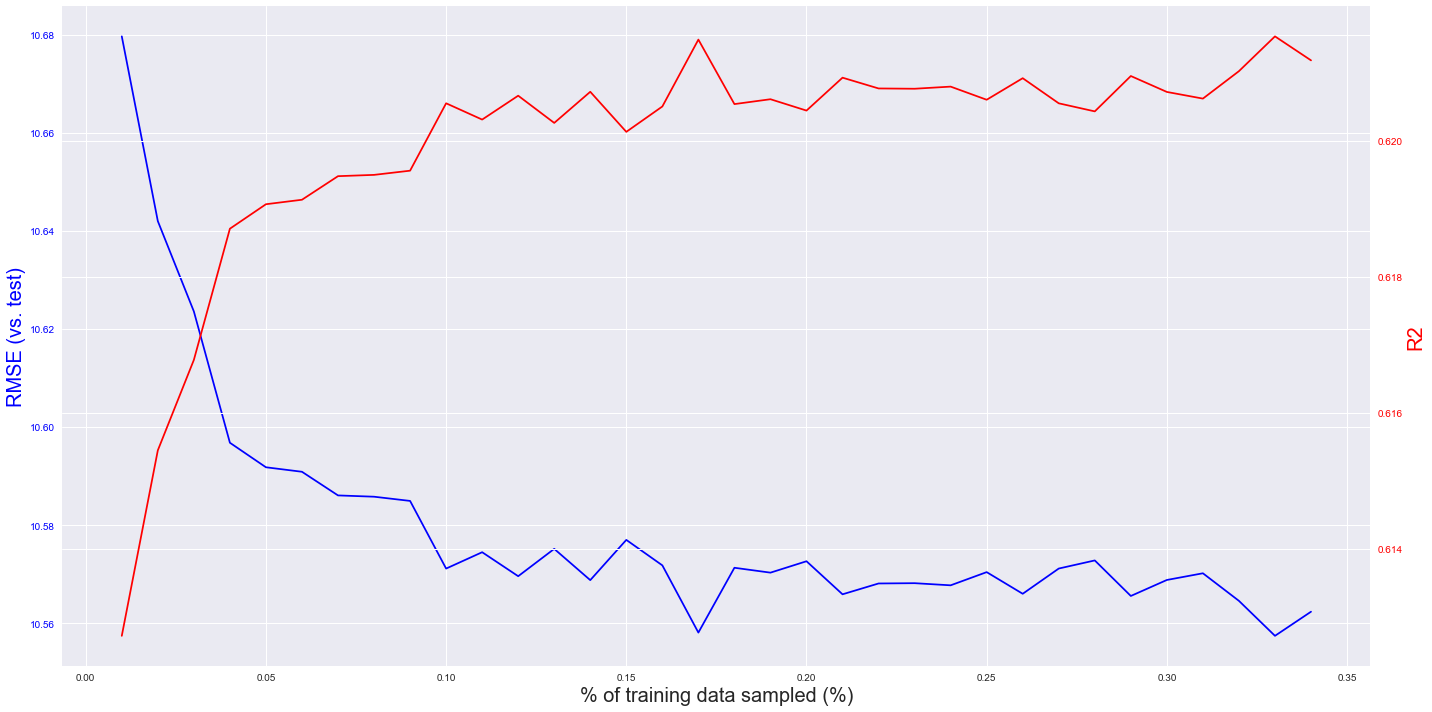

In [183]:
fig, ax1 = plt.subplots(figsize=(20,10))
t = [row[1] for row in results_array]
s1 = [row[3] for row in results_array]
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('% of training data sampled (%)',fontsize=20)
ax1.set_ylabel('RMSE (vs. test)', color='b',fontsize=20)
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = [row[4] for row in results_array]
ax2.plot(t, s2, 'r-')
ax2.set_ylabel('R2', color='r',fontsize=20)
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

With ~20% appearing to be the level that the model performance increases flatten out, we can move onto the gridsearching.

Similiar to the memory footprint optimisation in part 2, part 3 will have a focus on CPU efficiency.

By shrinking the dataset by 5, for approximately the same learning value, substantially more gridsearches can be ran (or, the same number faster!)

The next step is to run the most efficient XGBoost implementation possible. I struggled with the compilation on the Mac (instructions here : <https://github.com/dmlc/xgboost/blob/master/doc/build.md>), but, I was able to compile a multithreaded version for Windows, using the instructions here:  <https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_For_Anaconda_on_Windows?lang=en>

This allowed the fastest operation possible. (Interestingly, it was quicker to run one gridsearch on a multithreaded xgboost instance, than four gridsearches on single thread instances).

Next step is to chose the hyper parameter ranges (<http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html#control-overfitting>), and search!

In [ ]:
sample = 0.2 # 20% sample of the training data.

# same method as before, combine X + y, sample, then split back into xgboost compatible matrix

test_sample_df = pd.concat([X_train.reset_index(),
                            pd.DataFrame(y_train,columns=['age'])],axis=1).sample(int(X_train.shape[0]*sample)).iloc[:,1:]
train_X = test_sample_df.iloc[:,0:98].as_matrix()
train_y = test_sample_df['age'].as_matrix()


# instantiate the model
xgb_model = xgb.XGBRegressor()

# chosen hyper parameters
clf = GridSearchCV(xgb_model,
                   {'max_depth': [3,5,7,10],
                    'learning_rate':np.arange(0.0,0.5,0.10),
                    'n_estimators': [50,400,1000],
                    'gamma':[0.0,0.15,0.3]}, verbose=2, cv=4)

clf.fit(train_X,train_y)
print(clf.best_score_)
print(clf.best_params_)

Results cropped to save screen space!

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 450.6min finished
0.62761281358

{'n_estimators': 50, 'learning_rate': 0.10000000000000001, 'max_depth': 10, 'gamma': 0.15}
In [29]:

So, we have an R2 of >0.62 - an noticable increase on the linear model's result of 0.608588297471

Let's apply these hyper parameters to the full set of training data!

In [197]:
# parameters as defined by the gridsearch

param = {'n_estimators': 50, 'learning_rate': 0.10000000000000001, 'max_depth': 10, 'gamma': 0.15}

# fit this model off the entire training set
data = np.array(X_train.iloc[:,0:98].values)
label = y_train
dtest = xgb.DMatrix(X_test.values)
dtrain = xgb.DMatrix(data, label=label)

bst = xgb.train(param, dtrain)
        
predictions = bst.predict(dtest)

print "RMSE: ", mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))**0.5
print "R2: ", r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))


RMSE:  11.9368549478
R2:  0.51618065288


So, here we face a substantial problem. The optimised gridsearched hyper parameters, derived from a crossvalidated 20% sample of the training data (so, 10% of the overall data), is performing *worse* than the linear model, and earlier test xgboosts!!

What I believe is happening here is a twist in the methodology. The gridsearch was scored on its kfold/crossvaldiated, smaller dataset. This means it was both trained on less data, and tested on less data.

This means that it was prefering smaller, simpler models, which underfit vs. the larger test data set, giving a worse score when scaled. It is important to remember that the learning curve was derived from the default model performance agains the full 50% training stack, not a cross validated smaller % of the training data.

This unfortunately means that the hyper perameters are not useful, and neither is the gridsearchcv model when applied as I did.

There are two options - create a manual gridsearch method based on the same theory, but scored the same way as my other tests, and ran against all data. This unfortunately would be a very slow process computationally. Instead, I will look at running a 'manual' gridsearch, tuning parameters one by one, in order of descending importance, with the model scored against it's performance against the 50% data set.

(As a side, when I have more time, I will also re-run the gridsearchcv, but on 100% of the data, where I assume it'll come up with higher numbers on most key hyper parameters).

First parameter to tune - max_depth

In [199]:
def plot_uni_grid(results_array,feature_name):

    fig, ax1 = plt.subplots(figsize=(20,10))
    t = [row[0] for row in results_array]
    s1 = [row[1] for row in results_array]
    ax1.plot(t, s1, 'b-')
    ax1.set_xlabel(feature_name,fontsize=20)
    ax1.set_ylabel('RMSE (vs. test)', color='b',fontsize=20)
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    s2 = [row[2] for row in results_array]
    ax2.plot(t, s2, 'r-')
    ax2.set_ylabel('R2', color='r',fontsize=20)
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    plt.show()

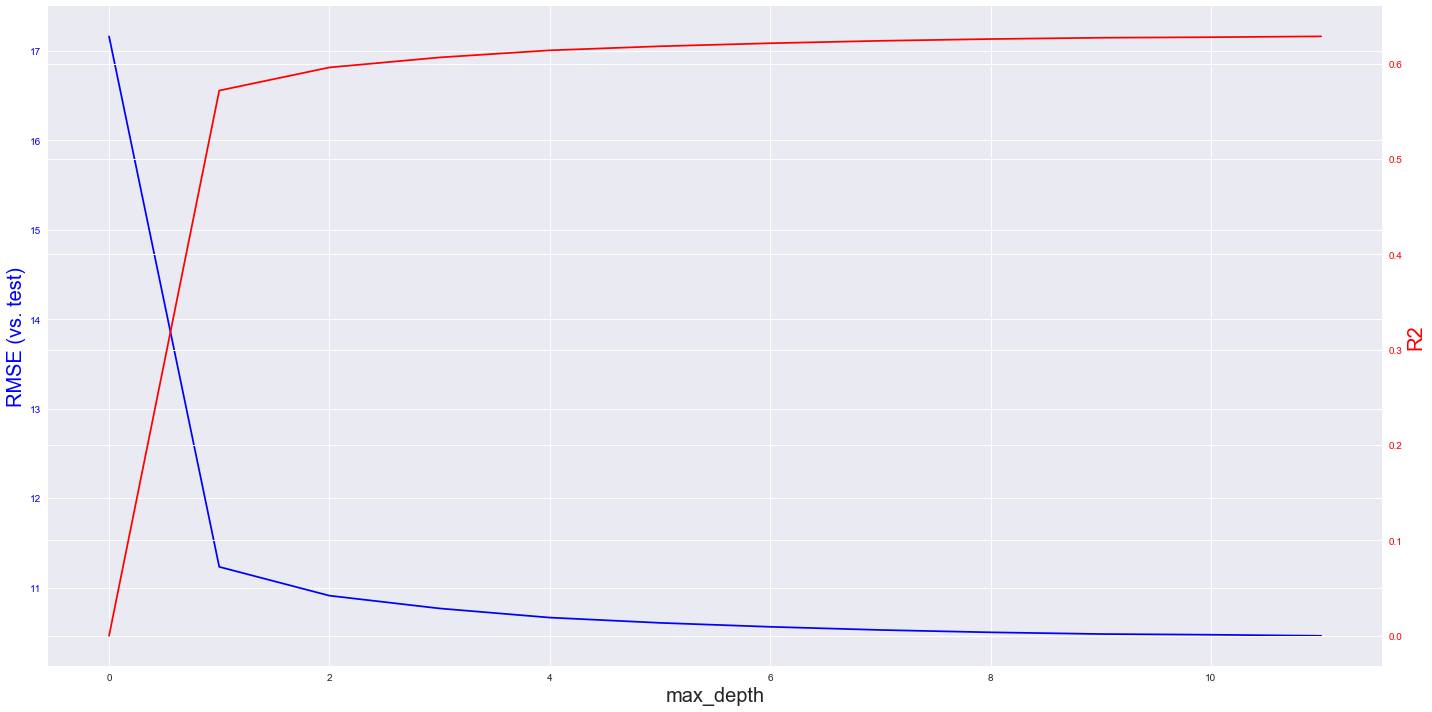

In [200]:
data = np.array(X_train.iloc[:,0:98].values)
label = y_train
dtest = xgb.DMatrix(X_test.values)
dtrain = xgb.DMatrix(data, label=label)

results_array = []

for max_depth in range(0,12):
    
    bst = xgb.train({'max_depth':max_depth}, dtrain)   
    predictions = bst.predict(dtest)
    
    rmse = mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))**0.5
    r2 = r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))

    results_array.append([max_depth,rmse,r2])
    
plot_uni_grid(results_array,'max_depth')

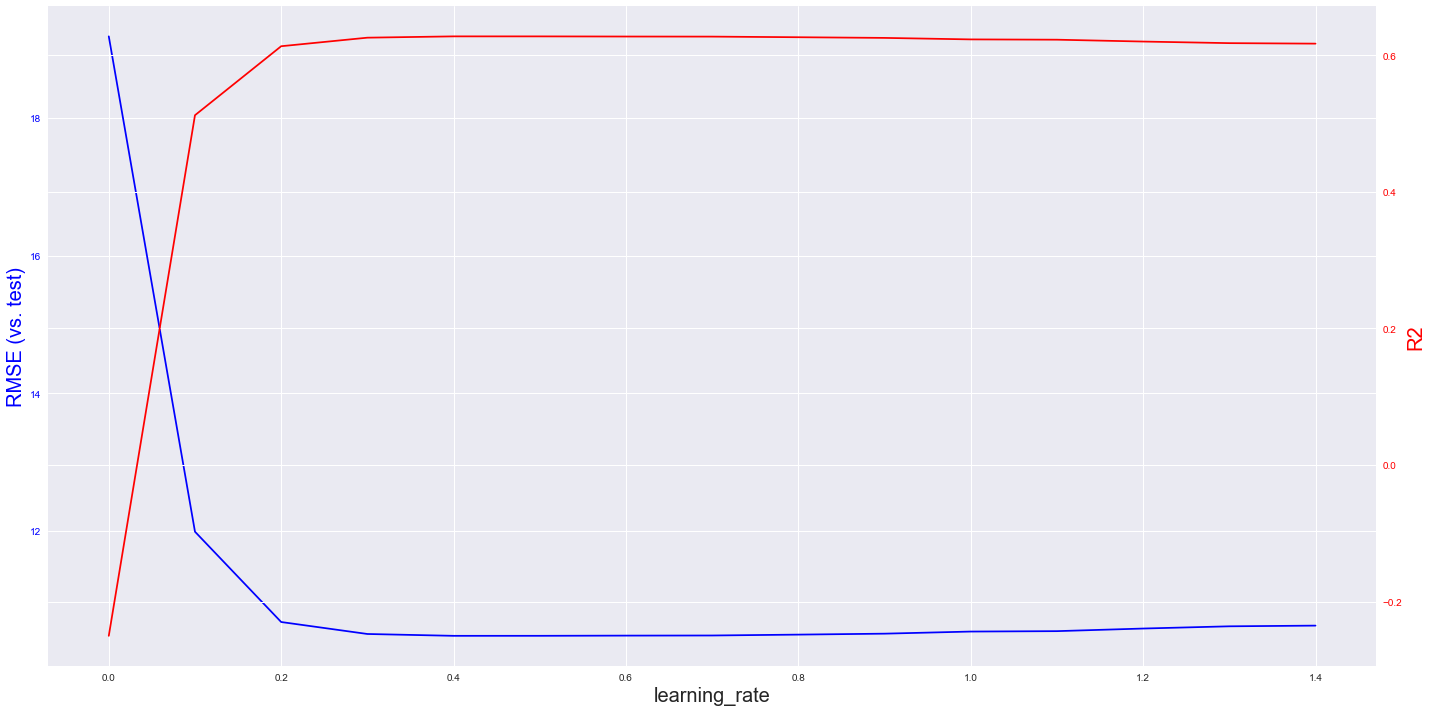

In [210]:
results_array = []

#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

for learning_rate in np.arange(0.0,1.5,0.1):
    
    bst = xgb.train({'max_depth':8, 'learning_rate':learning_rate}, dtrain) 
    predictions = bst.predict(dtest)
    
    rmse = mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))**0.5
    r2 = r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))

    results_array.append([learning_rate,rmse,r2])
    
plot_uni_grid(results_array,'learning_rate')

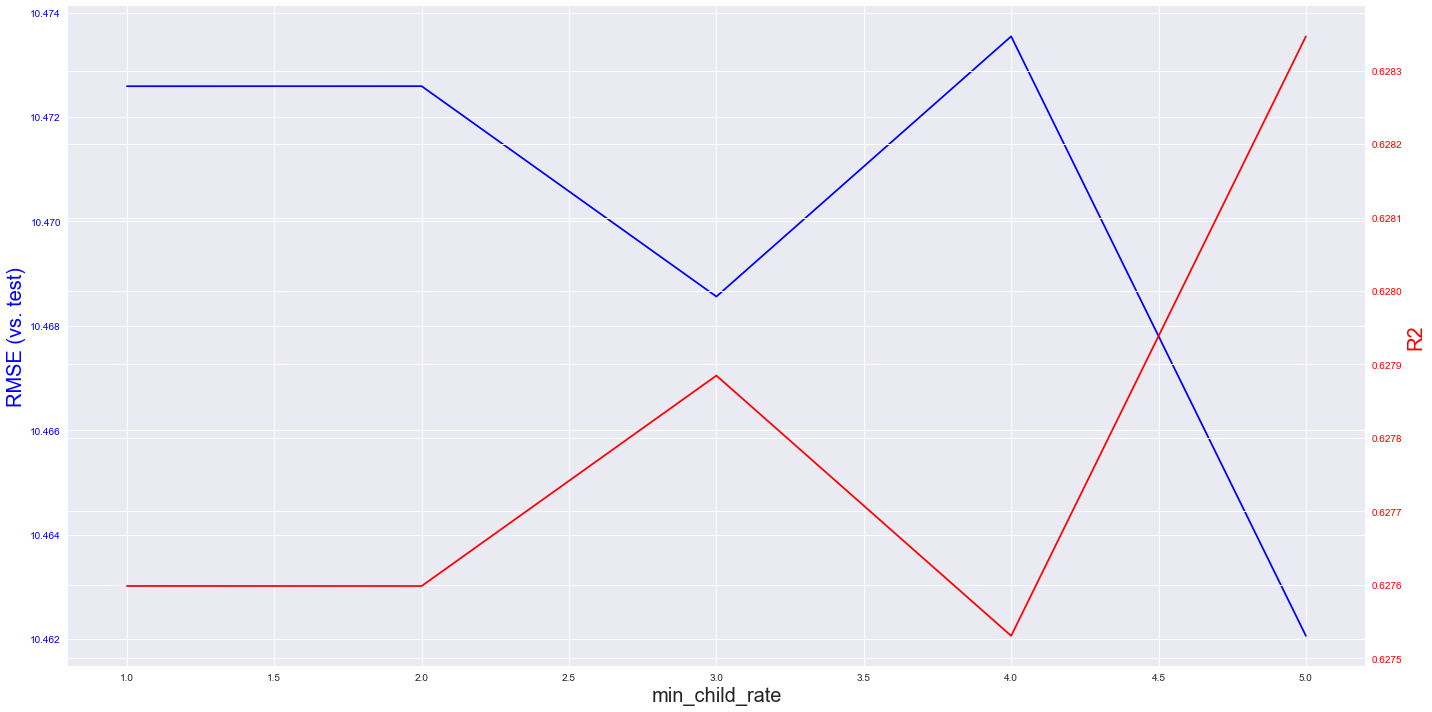

In [211]:
results_array = []

for min_child_weight in range(1,6,1):
    
    bst = xgb.train({'max_depth':8, 'learning_rate':0.4, 'min_child_weight':min_child_weight}, dtrain)
    predictions = bst.predict(dtest)
    
    rmse = mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))**0.5
    r2 = r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))

    results_array.append([min_child_weight,rmse,r2])
    
plot_uni_grid(results_array,'min_child_rate')

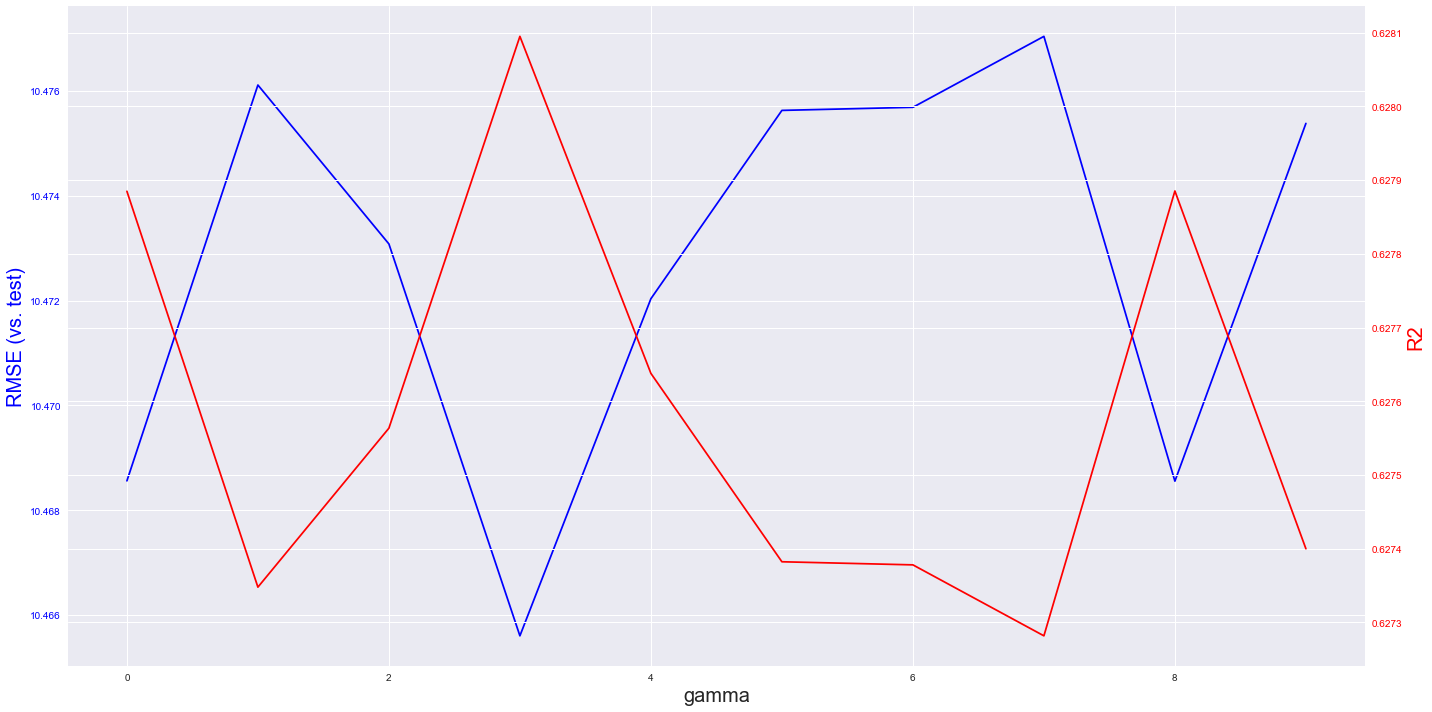

In [212]:
#https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6

results_array = []

for gamma in range(0,10,1):
    
    bst = xgb.train({'max_depth':8, 'learning_rate':0.4, 'min_child_weight':3,'gamma':gamma}, dtrain)
    predictions = bst.predict(dtest)
    
    rmse = mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))**0.5
    r2 = r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))

    results_array.append([gamma,rmse,r2])
    
plot_uni_grid(results_array,'gamma')

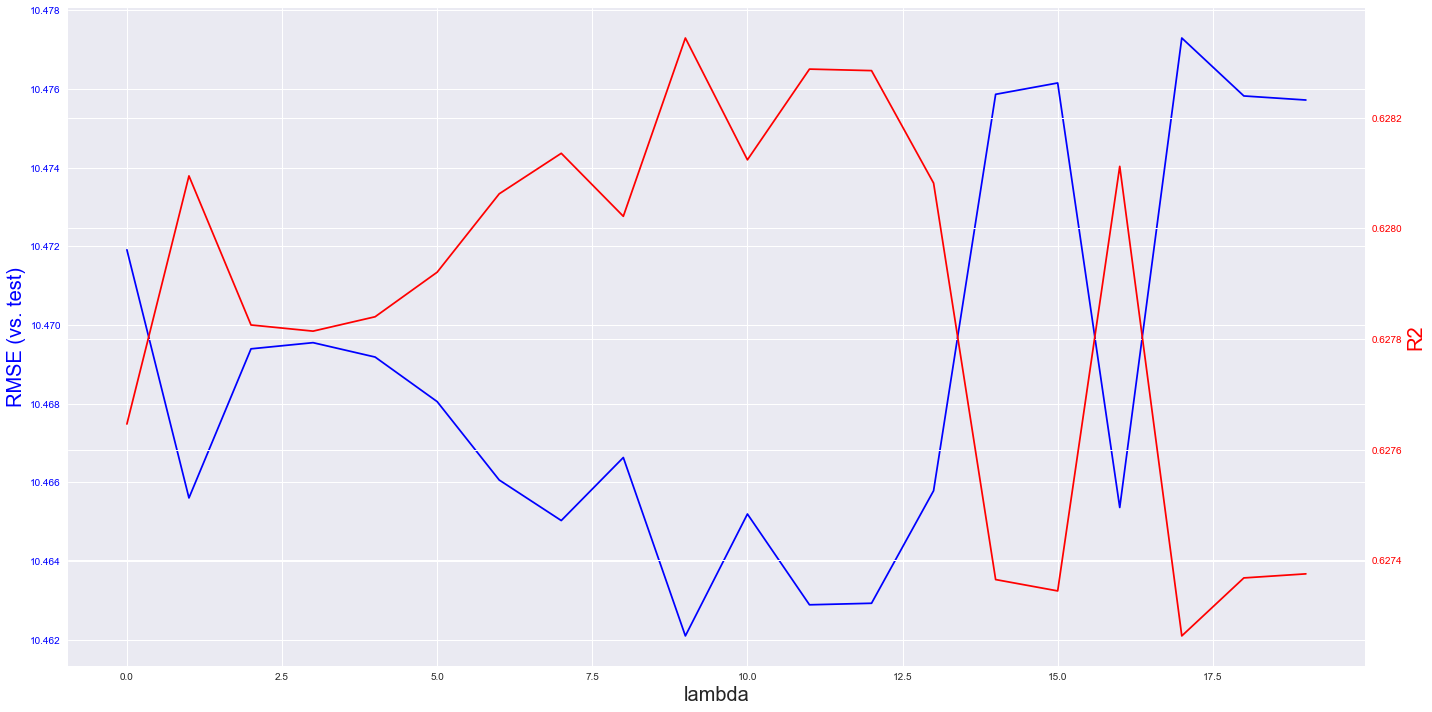

In [213]:

results_array = []

#lambda is a keyword in python, so, minor alteration of the variable name

for lambdo in range(0,20,1):
    
    bst = xgb.train({'max_depth':8, 'learning_rate':0.4, 'min_child_weight':3,'gamma':3, 'lambda':lambdo}, dtrain)
    predictions = bst.predict(dtest)
    
    rmse = mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))**0.5
    r2 = r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))

    results_array.append([lambdo,rmse,r2])
    
plot_uni_grid(results_array,'lambda')

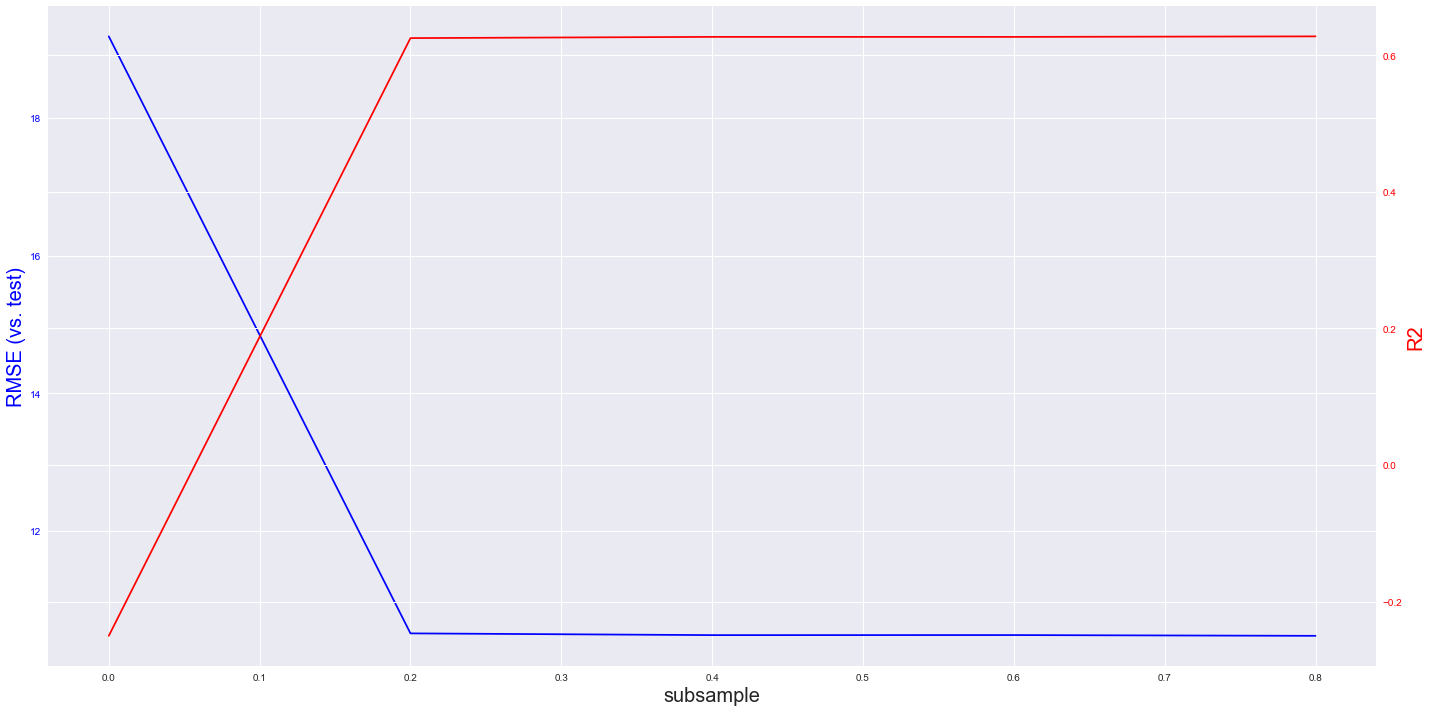

In [214]:

results_array = []

for subsample in np.arange(0,1,0.2):
    
    bst = xgb.train({'max_depth':8, 'learning_rate':0.4, 'min_child_weight':3,'gamma':3, 'lambda':9,'subsample':subsample}, dtrain)

    predictions = bst.predict(dtest)
    
    rmse = mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))**0.5
    r2 = r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))

    results_array.append([subsample,rmse,r2])
    
plot_uni_grid(results_array,'subsample')

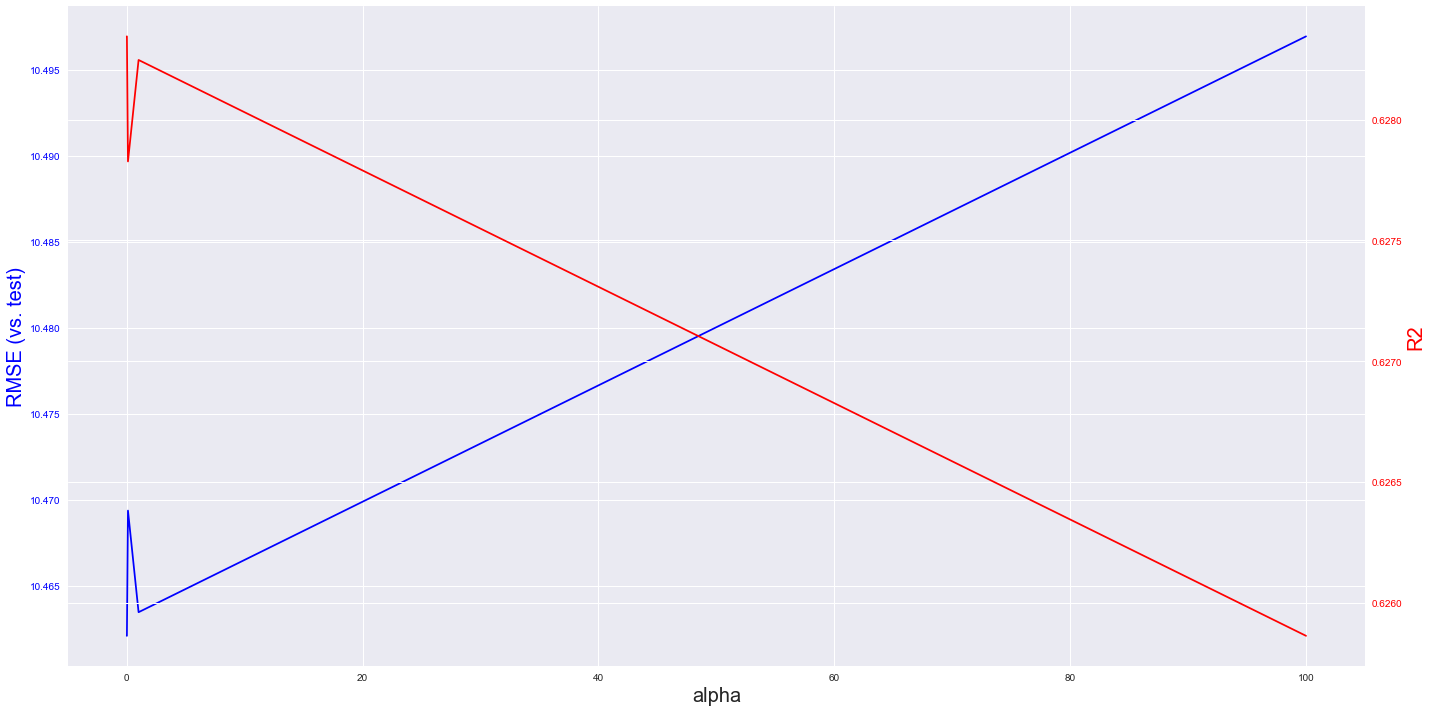

In [215]:
results_array = []

for alpha in [1e-5, 1e-2, 0.1, 1, 100]:
    
    bst = xgb.train({'max_depth':8, 'learning_rate':0.4, 'min_child_weight':3,'gamma':3, 'lambda':9,'subsample':1,'alpha':alpha}, dtrain)

    predictions = bst.predict(dtest)
    
    rmse = mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))**0.5
    r2 = r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))

    results_array.append([alpha,rmse,r2])
    
plot_uni_grid(results_array,'alpha')

Alpha only degraded performance above zero, so, especially as gamma was already set, it was left at default (0).

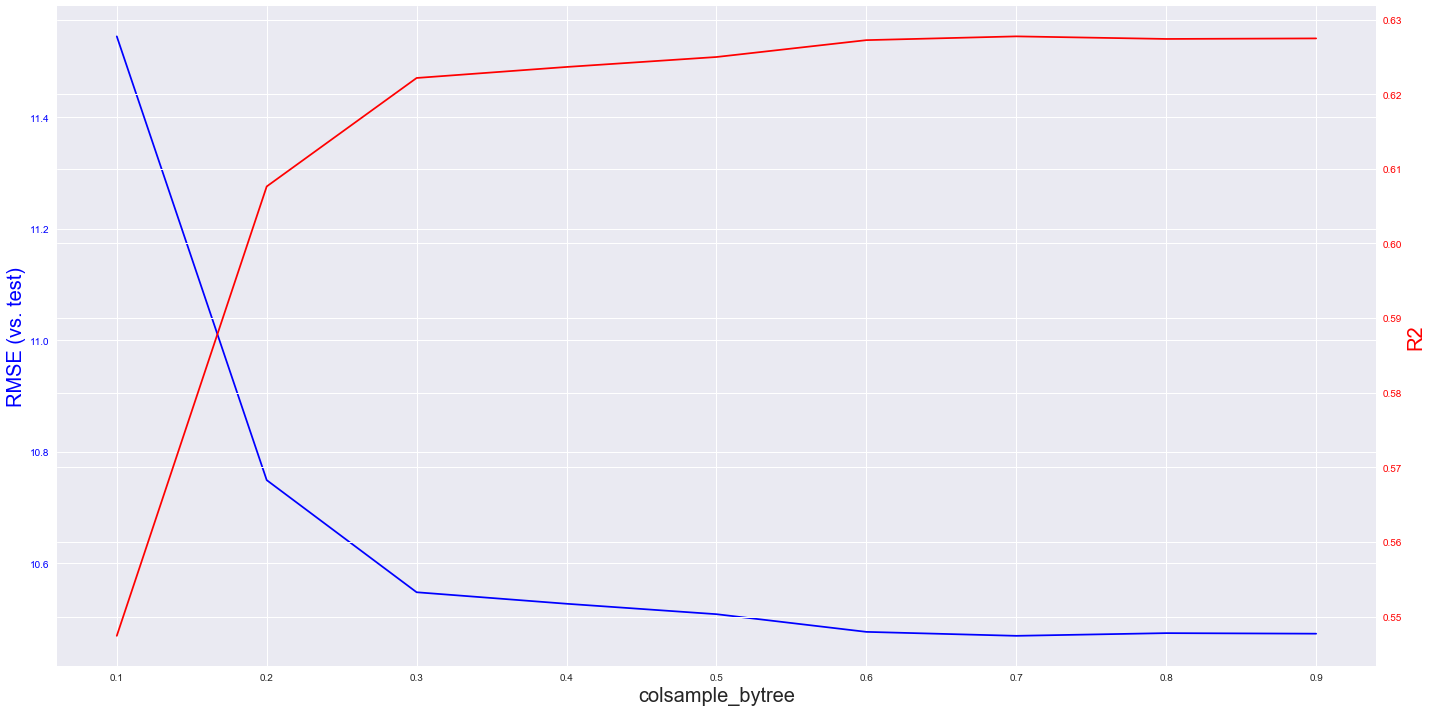

In [254]:
results_array = []

for colsample in np.arange(0.1,1.0,0.1):
    
    bst = xgb.train({'max_depth':8, 'learning_rate':0.4, 'min_child_weight':3,'gamma':3, 'lambda':9,'subsample':1,'colsample_bytree':colsample}, dtrain)

    predictions = bst.predict(dtest)
    
    rmse = mean_squared_error(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))**0.5
    r2 = r2_score(yscaler.inverse_transform(y_test), yscaler.inverse_transform(predictions))

    results_array.append([colsample,rmse,r2])
    
plot_uni_grid(results_array,'colsample_bytree')

So, after searching through eight dimensions, we finally have our first important modelling improvement on the original featureset.

In [255]:
print "RMSE: ",rmse
print "R2: ",r2

RMSE:  10.4741570599
R2:  0.627486889905


And, importantly, this score was achieved against the full test set (50% of customers), not a cross validated score.

This extra percentage of complexity comes at a cost though, with the model substantially more complex than the linear model. Here is just one of the boosted trees used:

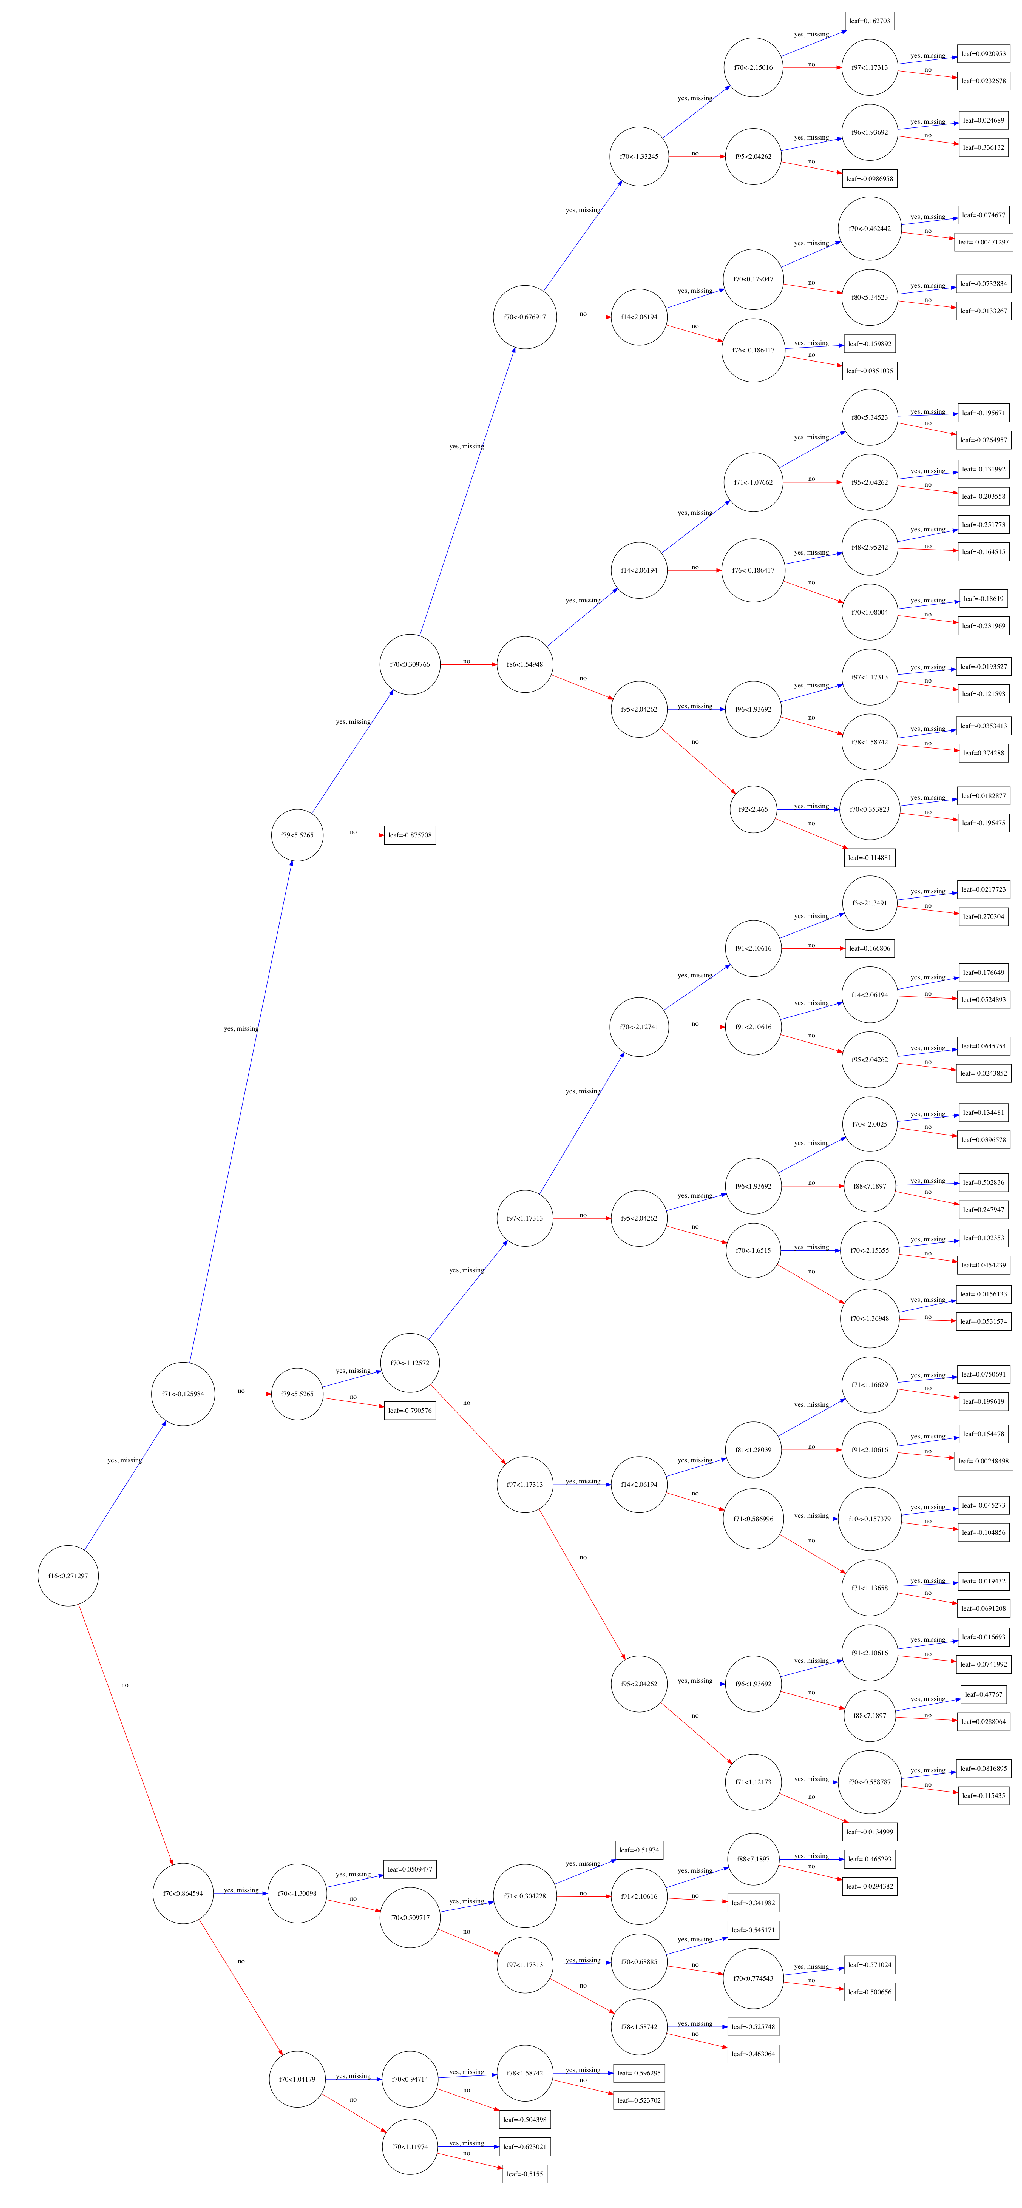

In [225]:
rcParams['figure.figsize'] = 40,40
xgb.plot_tree(bst, num_trees=0, rankdir='LR')

#http://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/

Let's see if the more complex model has re-prioritised features used?

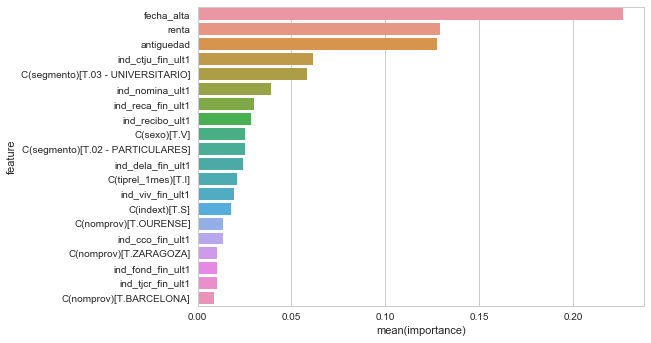

In [308]:
importance_list = []

for col, importance in zip(X_train.columns,gbm.feature_importances_):
    importance_list.append([col,importance])
    
importance_list = sorted(importance_list, key=lambda coef: coef[1],reverse=True)

importance_list = pd.DataFrame(importance_list,columns=["feature","importance"])

importance_list = importance_list.iloc[0:20,:]


fig = sns.barplot(x="importance", y="feature", data=importance_list)


In order to understand the error, to begin to hit our goal of halving it, lets view the residuals generated by the XGBoost model:

In [ ]:
rcParams['figure.figsize'] = 10,10

plot_df = pd.concat([pd.Series(yscaler.inverse_transform(bst.predict(dtest)),name="predictions"),pd.Series(yscaler.inverse_transform(y_test),name="y_test")],axis=1)

plot_df['residuals'] = plot_df['y_test'] - plot_df['predictions']

print plot_df.residuals.hist(bins=20).plot()

It becomes increasingly hard to visualise large volumes of data - in this case, 500k customer ages and predictions, but, predicted age vs. residuals provides an interesting view

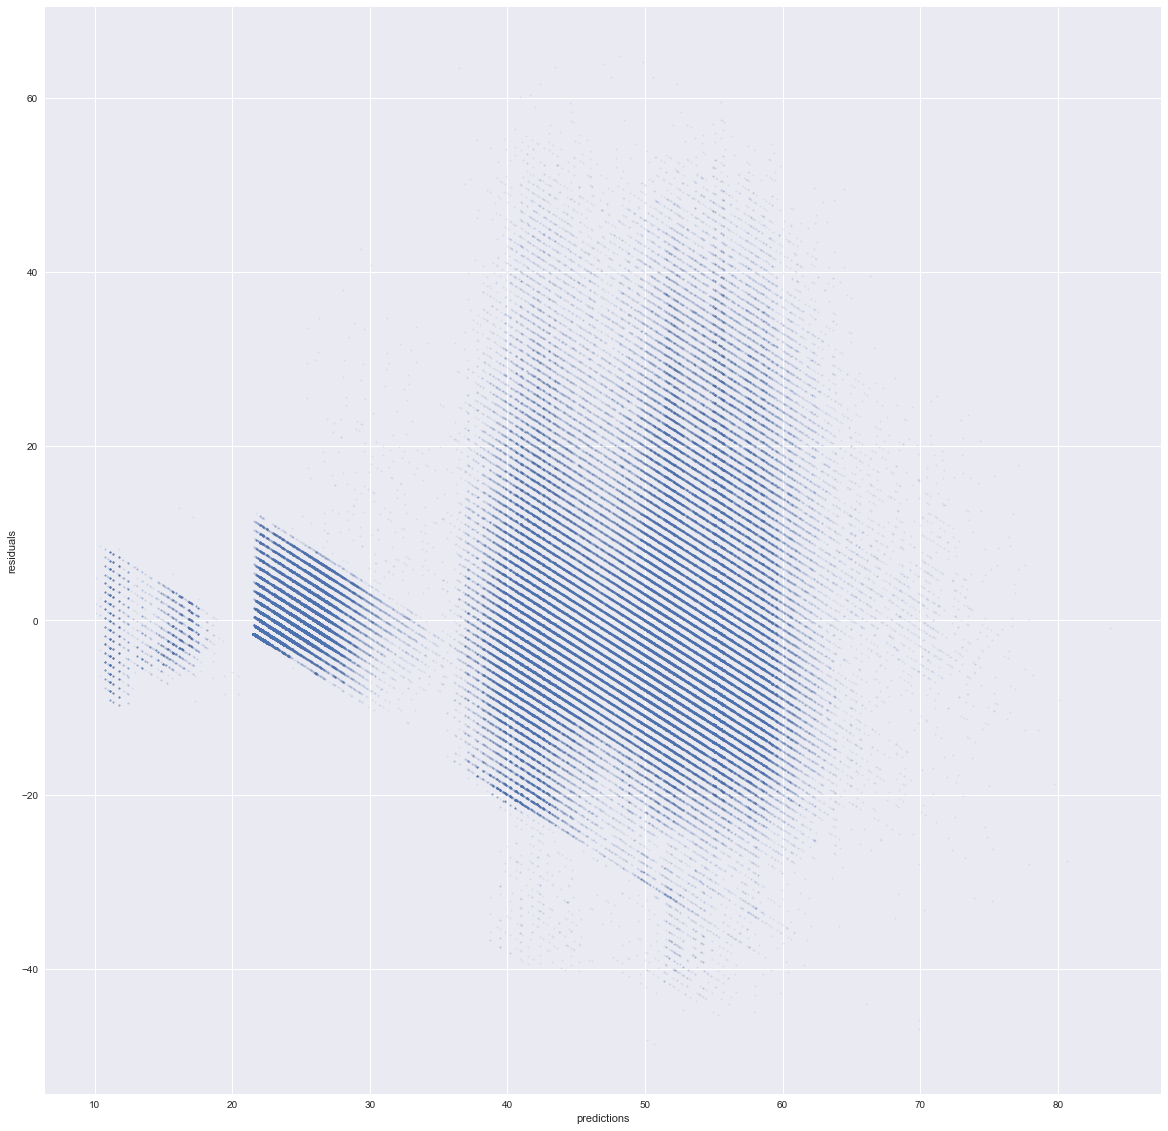

In [229]:
plot_df.plot(kind='scatter', x='predictions', y='residuals',alpha=0.1, s=2, figsize=(20,20))

We see three areas - on the far left, the junior users have the smallest residuals - controlled by their junior accounts. University age students, the next lump, have slightly broader residuals, but largely inside the target. However, the next body is where the trouble lies (and, the tails of the residuals histogram above). How we attack this is key to lowering the error.

One feature I intend to study for feature creation is the modal make up of ages per feature. We saw in the EDA that age was bimodal, but as we look per province, we can see how radically it can vary:

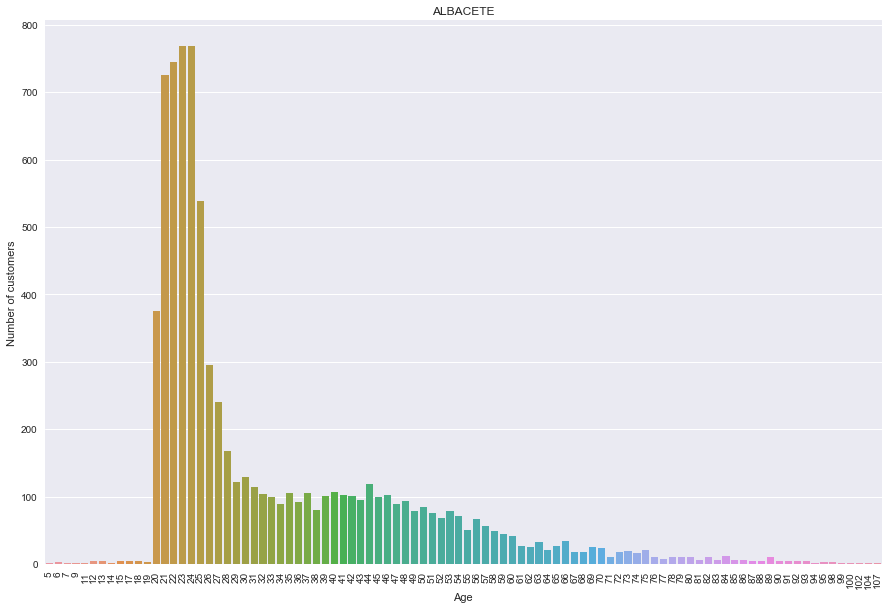

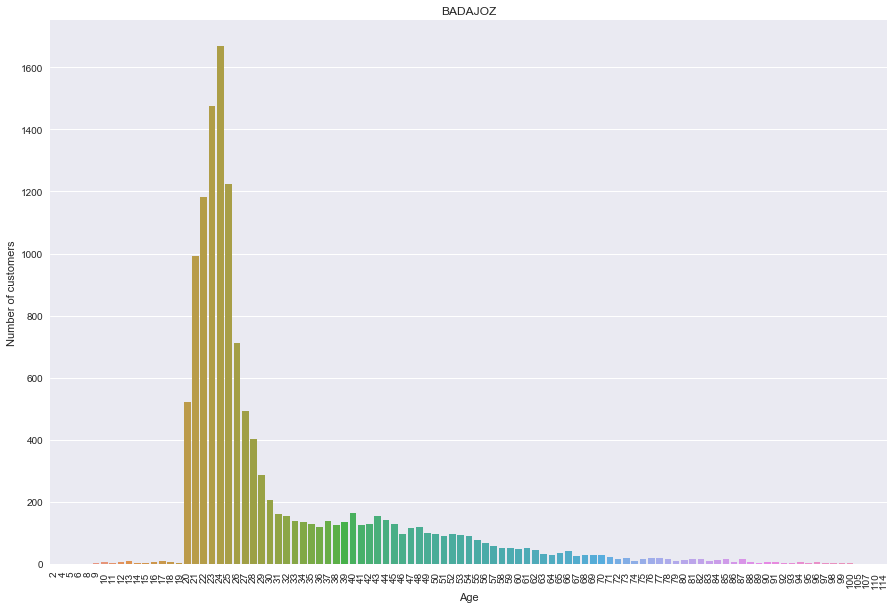

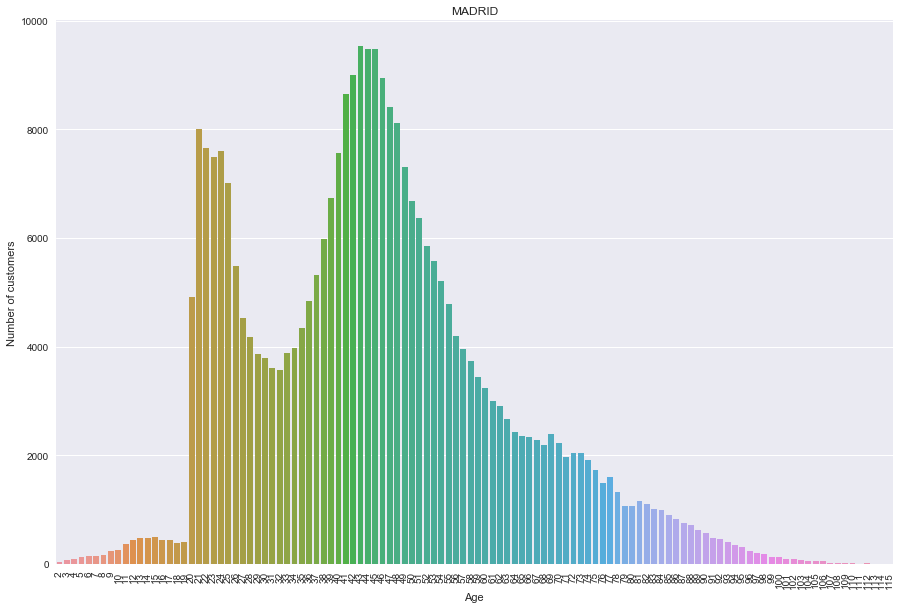

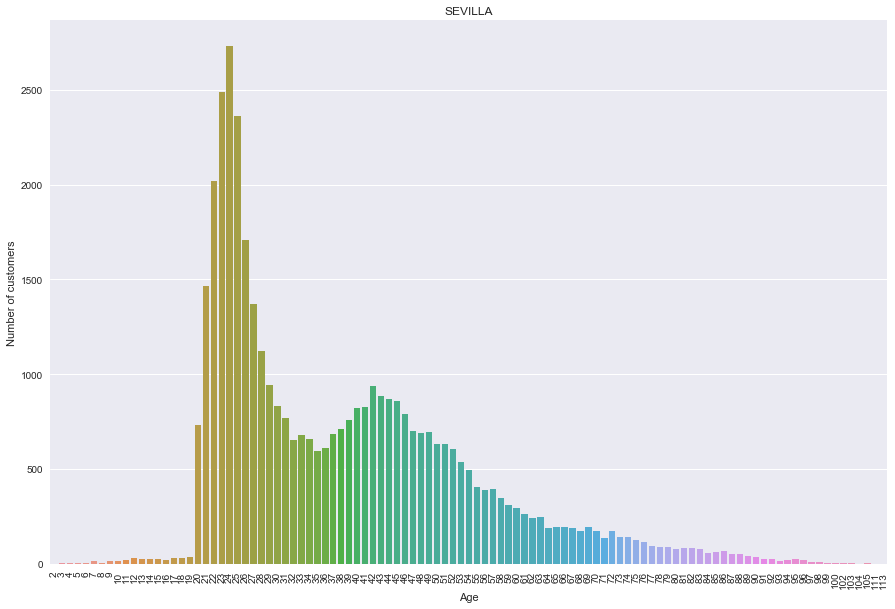

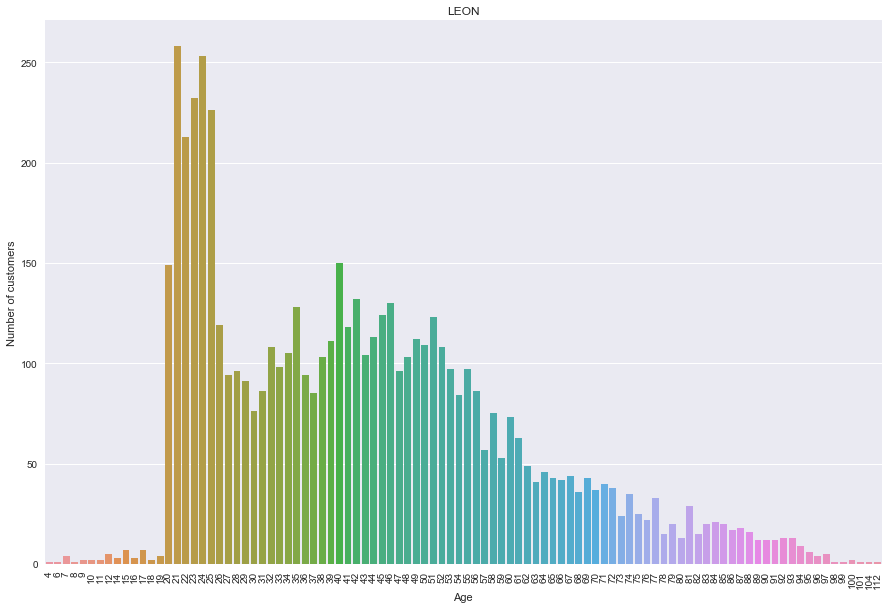

In [233]:
for area in df_age['nomprov'].unique()[1:6]:
    age_count = df_age[df_age['nomprov'] == area]['age'].value_counts()
    plt.figure(figsize=(15,10))
    plt.title(area)
    sns.barplot(age_count.index,age_count.values.astype(int))
    plt.xticks(rotation='vertical')
    plt.xlabel('Age')
    plt.ylabel('Number of customers')

My first avenue for experiment was to see if bimodality can be tested for statistically. This lead me to the work of Hartigan <https://projecteuclid.org/euclid.aos/1176346577>

I found an implementation of the dip test in Python and Cython, and set about testing provinces.

ALBACETE 0.0468200100553


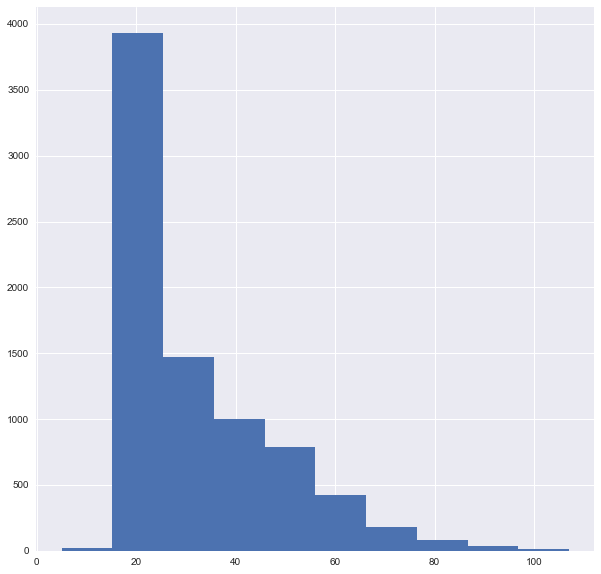

BADAJOZ 0.0463952695019


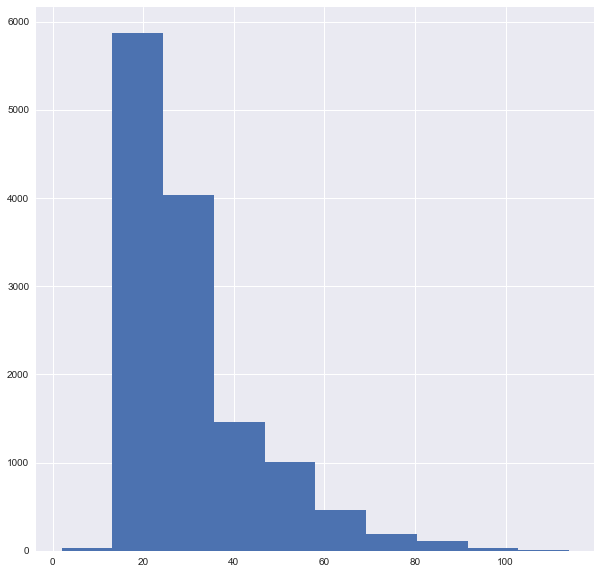

MADRID 0.0279988680652


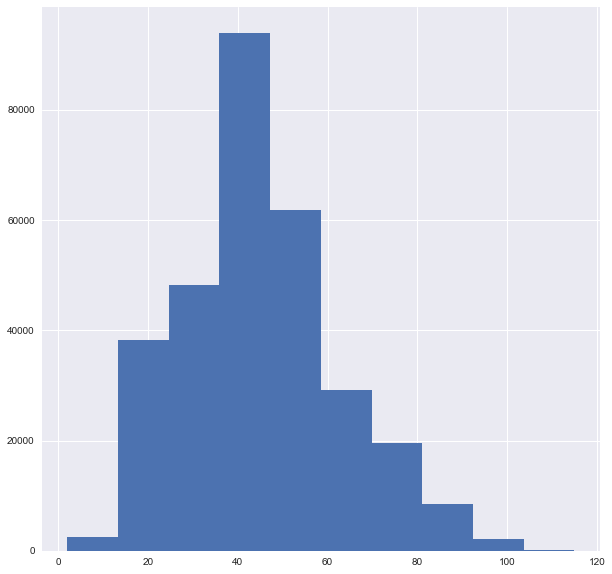

SEVILLA 0.0300850940386


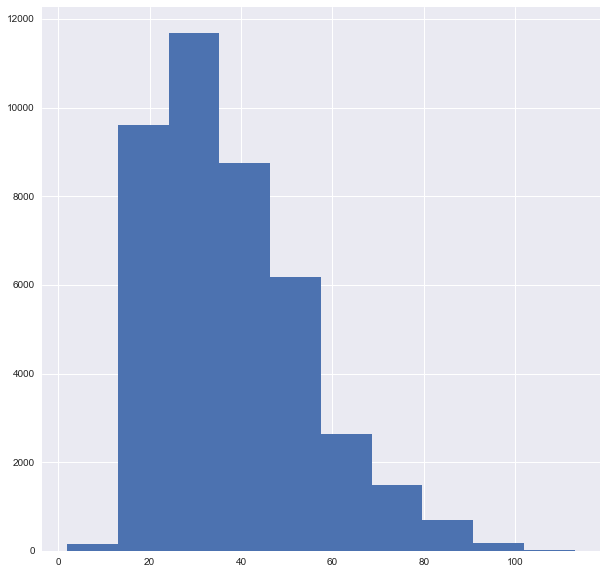

LEON 0.0215465849089


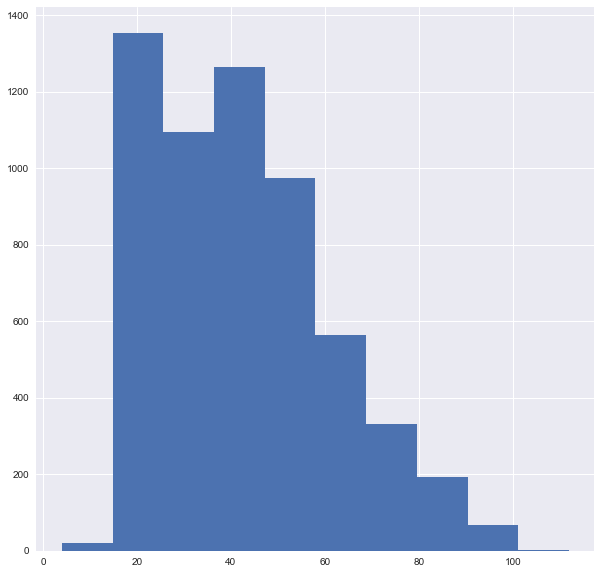

In [238]:
from diptest.diptest import dip

for area in df_age['nomprov'].unique()[1:6]:

    print area, dip(np.sort(df_age[df_age['nomprov'] == area]['age'].values))
    df_age[df_age['nomprov'] == area]['age'].hist(bins=10)
    plt.show()

Unfortunately, on the recommended test threshold of <0.05, practically all cities pass the test for bimodality. I need to find a new way to investigate this - perhaps running the test on a binned output, or on a smoothed curve, or by measuring maxima and minima of smoothed curves. I believe there is feature creation value in the area though.

Another area I didn't experiment with is XBGBoost's ability to cope with missing data - perhaps there is forecasting volume in there. I will produce a data set which is optimised, but not cleaned or imputed, to see if there is any predictive value there I would assume older customers may have had more IT system transfers, with data lost along the way. Conversely, I could believe younger users being privacy conscious, and wanting to withold data.

Another area I intend to explore is a full 'EDA' on the test data set with the predictions, and residuals, appended. By examining the (older) customers with the highest residuals and their features, it might give direction towards feature creation to correct it.

---

# Product recomendation

With the limit of the accuracy of the age prediction seemingly reached for now, lets take a couple of passes at the product recomendation, to establish the baseline and a couple of early model attempts.

## Product Reomendation baseline

The first importnant note is that as this task is spawned from a Kaggle, the scoring is based off a submitted file and confidential results, rather than a sample or cross valiadtion of the existing data. There is a limit of five submissions per day for scoring, so workflow will need to be designed around that limitation.

The submissions have to follow a fixed formed specified on the challenge's site:

<https://www.kaggle.com/c/santander-product-recommendation#evaluation>

---

###  _Submission File_

_For every user at each time point, you must predict a space-delimited list of the products they added. The file should contain a header and have the following format:_

ncodpers,added_products

15889,ind_tjcr_fin_ult1

15890,ind_tjcr_fin_ult1 ind_recibo_ult1

15892,ind_nomina_ult1

etc.

---

It is important to note that the file needs headers, and that the individual products are not seperated by columns, so a modified CSV export routing will need to be written to create compatible files.

A second note is that the submissions file, which takes the format of the 24 customer columns from June 2016, missing the product columns, has similiar data issues as test file. Lets load it and quickly review:

In [689]:
test_ver2 = pd.read_csv("../../../../capstone_assets/test_ver2.csv")

In [670]:
print test_ver2.shape

(929615, 24)


In [671]:
memory_footprint = test_ver2.memory_usage(index=False).sum()

print "Memory Footprint : %s GB" % round((float(memory_footprint) / (1024**3)), 2)

Memory Footprint : 0.17 GB


In [672]:
test_ver2.head().T

,0,1,2,3,4
fecha_dato,2016-06-28,2016-06-28,2016-06-28,2016-06-28,2016-06-28
ncodpers,15889,1170544,1170545,1170547,1170548
ind_empleado,F,N,N,N,N
pais_residencia,ES,ES,ES,ES,ES
sexo,V,H,V,H,H
age,56,36,22,22,22
fecha_alta,1995-01-16,2013-08-28,2013-08-28,2013-08-28,2013-08-28
ind_nuevo,0,0,0,0,0
antiguedad,256,34,34,34,34
indrel,1,1,1,1,1


In [674]:
test_ver2.isnull().sum()

fecha_dato                    0
ncodpers                      0
ind_empleado                  0
pais_residencia               0
sexo                          5
age                           0
fecha_alta                    0
ind_nuevo                     0
antiguedad                    0
indrel                        0
ult_fec_cli_1t           927932
indrel_1mes                  23
tiprel_1mes                  23
indresi                       0
indext                        0
conyuemp                 929511
canal_entrada              2081
indfall                       0
tipodom                       0
cod_prov                   3996
nomprov                    3996
ind_actividad_cliente         0
renta                         0
segmento                   2248
dtype: int64

Conyemp and ult_fec_cli_1t were both dropped from the earlier modelling feature set, and would be expected to be largely empty here (and, to have little to no effective impact on product selection).

In [677]:
test_ver2[test_ver2.segmento.isnull()].head(10).T

,33448,41188,46678,62165,64156,69980,78436,119268,125791,127534
fecha_dato,2016-06-28,2016-06-28,2016-06-28,2016-06-28,2016-06-28,2016-06-28,2016-06-28,2016-06-28,2016-06-28,2016-06-28
ncodpers,1138897,1126443,1151488,1244244,1242036,1233012,1268419,1018421,1011278,1008556
ind_empleado,N,N,N,N,N,N,N,N,N,N
pais_residencia,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES
sexo,H,H,H,H,H,V,V,V,V,H
age,48,38,44,61,39,48,47,36,40,46
fecha_alta,2013-08-27,2016-05-31,2013-09-07,2014-07-29,2014-02-05,2013-12-19,2014-07-11,2012-06-04,2012-05-04,2012-05-22
ind_nuevo,0,1,0,0,1,1,1,1,0,0
antiguedad,35,0,35,27,0,0,0,0,50,51
indrel,1,99,1,99,1,1,1,1,1,1


In [679]:
test_ver2[test_ver2.segmento.isnull()].conyuemp.value_counts(dropna=False)

NaN    2247
N         1
Name: conyuemp, dtype: int64

It appears there is a connection between customers missing the Segmento field, and missing the conyuemp field, suggesting it is an issue with a particular source of the data that Santander aggregated (or perhaps a result of anonymisation?). Conyuemp was whether the customer was a spouse of an employee or not, with >99% not the case, and the field was dropped. Segmento missing values were filled in with the median value (a standard customer, not a university student or a VIP). 

It looks like this test data set is consistent with the training. As the kaggle requires a prediction for all customers, the appropriate design descision will need to be taken to make the data, or model, consistent and valid across training and test.

Firstly, lets establish a baseline to compare future models against.

It could be fair to simply predict the seven most popular products, per customer, regardless of whether they currently have them or not. In some senses that would be the same as applying the mean to an age. However, to be more realistic, I think it would be fairer to create a baseline with slighly more substance.

I could imagine a marketing campaign today having a little more sophstication that just 'most popular' - lets increase the baseline and predict the 7 most popular products that the customer doesn't have yet - this could be  a realistic starting point for the campaign.

As the products are binary integers, measuring popularity should be a relatively simple summing process

In [682]:
product_popularity = train_ver2[product_columns].sum(axis=0)
product_popularity.sort_values(inplace=True,ascending=False)

In [683]:
product_popularity

ind_cco_fin_ult1     8938089
ind_ctop_fin_ult1    1759339
ind_recibo_ult1      1744789
ind_ecue_fin_ult1    1128015
ind_cno_fin_ult1     1103016
ind_nom_pens_ult1     809860
ind_nomina_ult1       745756
ind_reca_fin_ult1     706801
ind_tjcr_fin_ult1     605566
ind_ctpp_fin_ult1     590651
ind_dela_fin_ult1     586216
ind_valo_fin_ult1     349324
ind_fond_fin_ult1     252156
ind_ctma_fin_ult1     132254
ind_ctju_fin_ult1     129049
ind_plan_fin_ult1     125098
ind_hip_fin_ult1       80089
ind_viv_fin_ult1       52484
ind_pres_fin_ult1      34523
ind_deco_fin_ult1      23833
ind_deme_fin_ult1      22663
ind_cder_fin_ult1       5372
ind_ahor_fin_ult1       1396
ind_aval_fin_ult1        316
dtype: int64

This makes the most popular product the current account, which we knew from the EDA.

In [684]:
product_popularity.index[0]

'ind_cco_fin_ult1'

As the recomendations need to be submitted indexed on the customer ID, lets make the same chenage to the test data:

In [686]:
#test_ver2.set_index(keys='ncodpers',append=True,drop=True,inplace=True)

As a side note, this is another exercise where I had to improve my coding practices to be more Python and Pandas native, in order to calculate across the large dataset. My first attempt to apply the most popular products that each customer has, looked as follows:

In [687]:
# def baseline_recommender(input_customer):
#     rec_string = str()
#     rec_counter = 0
#     for product in product_popularity.index:
#         if train_ver2[train_ver2['ncodpers']==input_customer][product].sum() == 0 and rec_counter < 7:
#             rec_string = rec_string + product + ' '
#             rec_counter += 1
#     rec_string = [input_customer,rec_string[0:len(rec_string)-1]]
#     return rec_string

# #class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)

# product_recomendations = []

# import datetime

# then = datetime.datetime.now()


# print(then)

# for ncodper in test_ver2.ncodpers.sort_values()[0:100]:
#     product_recomendations.append(baseline_recommender(ncodper))
    
# now = datetime.datetime.now()

# print(now)

# print(now-then)

The logic, similiar to the income imputution, was to run the changes on a line per line basis. This fits computing logic, but was extremely slow - calculating 100 rows took 40 seconds. This means the full process would take > 100 hours, or four days. Because every loop required a Pandas aggregation table (line 5), that means multiple table creations per customer, and unfeasibly slow creation.

Taking learnings from the earlier optimisation exercise, where orders of magnitude of speed increases were attained by using native Pandas data structures, I looked to improve the code:

In [691]:
query_columns = ['ncodpers'] + product_columns

#We need to re-read the training data, as we need predictions for all customers, even those who have churned and were
# excluded from the original age dataframe, as per Santander's request.

history = pd.pivot_table(pd.read_csv("../../../../capstone_assets/train_ver2.csv",usecols=query_columns), index='ncodpers',aggfunc=np.sum)

# I take the full history of a customer's products, not just the latest month, as re-recommdning a product a customer
# has churned is instinctively unlikely to be a success.

def baseline_recommender(input_customer):
    rec_string = str()
    rec_counter = 0
    for product in product_popularity.index:
        if history.loc[input_customer,product] == 0 and rec_counter < 7:
            rec_string = rec_string + product + ' ' # appending a long string without commas
            rec_counter += 1
    rec_string = [input_customer,rec_string[0:len(rec_string)-1]]
    return rec_string

product_recomendations = []

import datetime

then = datetime.datetime.now()

print(then)

for ncodper in test_ver2.ncodpers.sort_values():
    product_recomendations.append(baseline_recommender(ncodper)) 
    
now = datetime.datetime.now()

print(now)

print(now-then)


2017-05-21 11:20:35.518086
2017-05-21 11:23:47.407926
0:03:11.889840


Here, rather than creating a reference table per loop, a single reference table is created outside the looped customer recommender.

This speeds up the process from over a hundred hours to under four minutes.

There are likely further optimisations that could be made, but, this is sufficient for a baseline calculation that won't be repeated often.

Lets export the array to CSV, and see what Kaggle says:

In [ ]:
pd.DataFrame(product_recomendations,columns=['ncodpers','added_products']).to_csv('../../../../capstone_assets/baseline_rec_01.csv',index=False)

# new baseline calculation

# Private Score
# 0.0085363
# Public Score
# 0.0085375
# Use for Final Score
# baseline_rec_01.csv
# 2 minutes ago by John Henry Mostyn
# 2017-05-17


This score would be roughly 1,500 of 1,800 on the public leaderboard, but, more importantly, gives some context to the max public score of 0.031.

I think though, to establish a real life baseline for the model, we should push further into the IT approach that could be taken to solve product recomendation marketing communicaiton on a simple level. To improve the model above by one stage, lets recomend per customer the most popular products for the people of their age, that they do not currently have (or have ever had).

In [697]:
pop_columns = ['age'] + product_columns
pop_per_age = pd.read_csv("../../../../capstone_assets/train_ver2.csv",usecols=pop_columns).groupby(by='age').sum()
pop_per_age.head()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
age,,,,,,,,,,,,,,,,,,,,,
2,0,0,7,0,0,447,0,0,0,0,...,22,0,0,0,0,0,0,0.0,0.0,0
3,0,0,2,0,0,1003,1,0,0,0,...,0,0,0,0,0,0,0,2.0,3.0,0
4,0,0,5,0,0,1326,0,0,0,0,...,0,0,0,0,0,0,0,0.0,8.0,0
5,0,0,6,0,0,1748,0,0,0,0,...,0,0,0,0,0,0,0,0.0,9.0,0
6,0,0,0,0,0,2269,0,0,0,0,...,0,0,0,0,0,0,0,0.0,8.0,0


In [698]:
pop_per_age.loc[2].sort_values(ascending=False).index

Index([u'ind_ctju_fin_ult1', u'ind_hip_fin_ult1', u'ind_cco_fin_ult1',
       u'ind_recibo_ult1', u'ind_deme_fin_ult1', u'ind_aval_fin_ult1',
       u'ind_cder_fin_ult1', u'ind_cno_fin_ult1', u'ind_ctma_fin_ult1',
       u'ind_ctop_fin_ult1', u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1',
       u'ind_dela_fin_ult1', u'ind_nom_pens_ult1', u'ind_ecue_fin_ult1',
       u'ind_fond_fin_ult1', u'ind_plan_fin_ult1', u'ind_pres_fin_ult1',
       u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1', u'ind_valo_fin_ult1',
       u'ind_viv_fin_ult1', u'ind_nomina_ult1', u'ind_ahor_fin_ult1'],
      dtype='object')

In [702]:
pop_by_age = {}
for age in test_ver2.age.value_counts().index.sort_values():
    if age > 116: # there is one bug in the test set - a 118 year old customer who was 117 in the test
            pop_by_age[age] = pop_per_age.loc[100].sort_values(ascending=False).index
    else:
        pop_by_age[age] = pop_per_age.loc[age].sort_values(ascending=False).index

query_columns = ['ncodpers'] + ['age'] + product_columns

history = pd.pivot_table(pd.read_csv("../../../../capstone_assets/train_ver2.csv",usecols=query_columns), index='ncodpers',aggfunc=np.sum)

def age_baseline_recommender(input_customer):
    rec_string = str()
    rec_counter = 0
    if input_customer[1] > 116:
        age_ = 100 ## cusomer
    else:
        age_ = int(input_customer[1])
    for product in pop_by_age[age_]:
        if history.loc[input_customer[0],product] == 0 and rec_counter < 7:
            rec_string = rec_string + product + ' '
            rec_counter += 1
    rec_string = [input_customer[0],rec_string[0:len(rec_string)-1]]
    return rec_string

#class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)

product_recomendations = []

for customer in test_ver2[['ncodpers','age']].sort_values(by='ncodpers').values:
    product_recomendations.append(age_baseline_recommender(customer))



As before, lets upload this to kamggle for scoring:

In [ ]:
pd.DataFrame(product_recomendations,columns=['ncodpers','added_products']).to_csv('../capstone_assets/baseline_rec_02.csv',index=False)

In [ ]:
# Submission and Description
# second baseline - recomendations based on descending popularity per product per age

# Private Score
# 0.0098396


# Public Score
# 0.009841

# Use for Final Score
# baseline_rec_02.csv
# 3 days ago by John Henry Mostyn



I think this idea of a baseline led around the accuracy of conventional, 'IT' lead benchmarks is a very interesting one. Recommending products in customers based on the most popular ones in their age category would be fairly sophisticated direct marketing a decade ago, but now the challenge is to see how modern Data Science theory and tools can improve upon it!

So, for my first pass at future product prediction, I am going to take the model successfully used in age prediction, XGBoost, and apply it to product sets. The theory is as follows :

* Use April products as a training set for May as a target
* Run a model per product, trained using the previous month's products
* From the proba of each product, derive those most likely to be picked up per customer.

This is a very first pass at collaborative filtering. The further expansions would be to use product history, to factor in seasonality (through a mix of EDA and modelling), and to introduce the 24 customer specific features.

In [ ]:
print(datetime.datetime.now())

usecols = ['ncodpers'] + ['fecha_dato'] + product_columns

df_train = pd.read_csv('../../../../capstone_assets/train_ver2.csv', usecols=usecols, parse_dates=['fecha_dato'], infer_datetime_format=True)

dftr_prev = df_train[df_train['fecha_dato'].isin(['28-04-2016'])]
dftr_curr = df_train[df_train['fecha_dato'].isin(['28-05-2016'])]

dftr_prev.drop(['fecha_dato'], axis=1, inplace = True)
dftr_curr.drop(['fecha_dato'], axis=1, inplace = True)

dfm = pd.merge(dftr_curr,dftr_prev, how='inner', on=['ncodpers'], suffixes=('', '_prev'))

prevcols = [col for col in dfm.columns if '_ult1_prev' in col]
currcols = [col for col in dfm.columns if '_ult1' in col and '_ult1_prev' not in col]

for cols in currcols:
    print(cols)
    dfm[cols] = dfm[cols].astype('category')

for cols in prevcols:
    print(cols)
    dfm[cols] = dfm[cols].astype('category')

dfm.fillna(0, inplace=True)

models = {}
model_preds = {}
id_preds = defaultdict(list)

model_preds_train = {}
id_preds_train = defaultdict(list)

ids = dfm['ncodpers'].values
testids = dftr_curr['ncodpers'].values

prevcols = [col for col in dfm.columns if '_ult1_prev' in col]
currcols = [col for col in dfm.columns if '_ult1' in col and '_ult1_prev' not in col]

for c in dfm.columns:
    if c != 'ncodpers' and '_ult1_prev' not in c:
        print(c)
        y_train = dfm[c]
        x_train = dfm.drop(currcols,1,inplace=False).drop(['ncodpers'],1,inplace=False)
        x_test = dftr_curr.drop(['ncodpers'],1,inplace=False)
        
        # gridsearch hyper parameters picked from an earlier grid search, not included here because of time to re-calculate
        # I would like to refine gridsearch further, possibly tuning a model per product, as the impact of tuning was substantial

        xgbgss = XGBClassifier(objective="binary:logistic",gamma=9.5388253972042545,learning_rate= 0.22150383938489421, max_depth= 35,
n_estimators=7)
        xgbgss.fit(x_train.as_matrix(), y_train)
        p_train = xgbgss.predict_proba(x_train.as_matrix())[:,1]
        p_test = xgbgss.predict_proba(x_test.as_matrix())[:,1]
        
        models[c] = xgbgss
        model_preds[c] = p_test
        for id, p in zip(testids, p_test):
            id_preds[id].append(p)
            
        model_preds_train[c] = p_train
        for id, p in zip(ids, p_train):
            id_preds_train[id].append(p)
            
        print(roc_auc_score(y_train, p_train))
        
already_active = {}

dftrcurr = dftr_curr

for row in dftrcurr.values:
    row = list(row)
    id = row.pop(0)
    active = [c[0] for c in zip(dftrcurr.columns[1:], row) if c[1] > 0]
    already_active[id] = active

test_preds = {}
for id, p in id_preds.items():
    preds = [i[0] for i in sorted([i for i in zip(dftrcurr.columns[1:], p) if i[0] not in already_active[id]], key=lambda i:i [1], reverse=True)[:7]]
    test_preds[id] = preds

sample = pd.read_csv('../../../../capstone_assets/sample_submission.csv')

test_preds_prods = []
for row in sample.values:
    id = row[0]
    p = test_preds[id]
    test_preds_prods.append(' '.join(p))

sample['added_products'] = test_preds_prods

sample.to_csv('../../../../capstone_assets/xgboost_2nd_2017_05_17.csv', index=False)



In [1]:
#Submission and Description
#xgboost_2nd_2017_05_17
#2nd xbg attempt, purely on products


#Private Score
#0.023357
#Public Score
#0.0230254


So, we see over twice the sore of the baseline - a strong message there is value in this modelling, and in using data science to tackle marketing communication challenges. It is difficult to quantify the baseline I set at the start of the exercise - to beat a human bank sales person at prediction, but I think if it hasn't happened it is close - this model is picking up more than the popular products to beat teh numeric baseline, and it hasn't even been trained on personal data yet.

## Code deployment

One of the advantages of XGBoost is it designed around scalability and deployment. It can be implmented across clusters using Scala, Spark and Flask, which could be useful for tuning hyperparamters further.

For the actual prediction though, the model(s) are small enough that they can be run on a single machine, inside the marketing communications workflow, and perhaps even feeding into the customer advisors IT systems.

XGBoost allows the export of models:

<http://xgboost.readthedocs.io/en/latest/python/python_intro.html>

In [3]:
# The model and its feature map can also be dumped to a text file.

# # dump model
# bst.dump_model('dump.raw.txt')
# # dump model with feature map
# bst.dump_model('dump.raw.txt','featmap.txt')
# A saved model can be loaded as follows:

# bst = xgb.Booster({'nthread':4}) #init model
# bst.load_model("model.bin") # load data


So, the model per product could be exported, and ran inside the production environment and fed into communications workflows

In terms of retaining the model, more work would have to be done on seasonality to really understand how often it owuld need to be re-run. A number of interesting questions are raised when considering how these tools could be used to market *new* products - could market research and marieting expertise to built into an ensemble recomendation method to predict customers for products in the pipeline with no history? That would be  avery interesting further challenge to work on.